In [1]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from typing import Iterable, Optional, Tuple
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")
from sklearn.neural_network import MLPRegressor  # Alternativa a redes neuronales de TensorFlow
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import make_scorer

In [2]:
#Carga de datos
ruta = 'Datos_Ventas_Stock_Calendario.csv'
datos_ventas_stock_calendario = pd.read_csv(ruta, sep=",")
datos_ventas_stock_calendario['idSecuencia'] = pd.to_datetime(datos_ventas_stock_calendario['idSecuencia'])
datos_ventas_stock_calendario.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 653514 entries, 0 to 653513
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   producto     653514 non-null  int64         
 1   idSecuencia  653514 non-null  datetime64[ns]
 2   udsVenta     653514 non-null  int64         
 3   udsStock     653514 non-null  int64         
 4   bolOpen      653514 non-null  int64         
 5   bolHoliday   653514 non-null  int64         
 6   isPromo      653514 non-null  int64         
 7   año          653514 non-null  int64         
 8   mes          653514 non-null  int64         
 9   dia          653514 non-null  int64         
 10  dia_semana   653514 non-null  int64         
 11  semana       653514 non-null  int64         
 12  semana_mes   653514 non-null  int64         
dtypes: datetime64[ns](1), int64(12)
memory usage: 64.8 MB


# Outliers

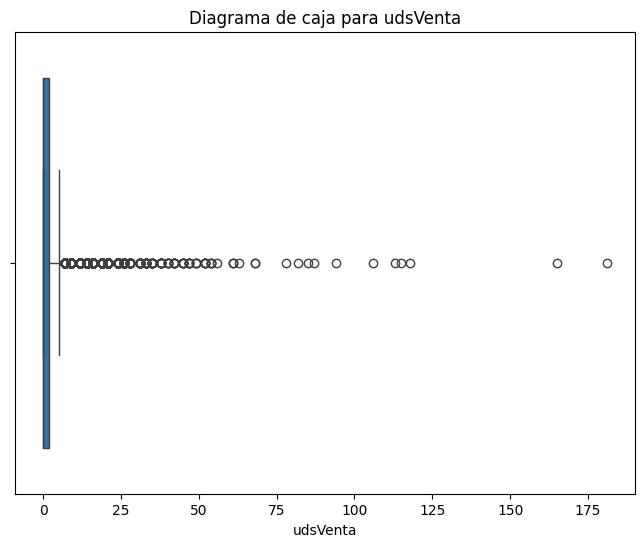

In [3]:

# Crear un diagrama de caja para identificar outliers en udsVenta
plt.figure(figsize=(8, 6))
sns.boxplot(x=datos_ventas_stock_calendario['udsVenta']) 
plt.title('Diagrama de caja para udsVenta')
plt.xlabel('udsVenta')
plt.show()

Para el tratamiento de valores atípicos se aplica un suavizado basado en medias móviles y desviaciones estándar calculadas por producto. Este enfoque contextualiza cada observación dentro de la dinámica temporal específica de la referencia, evitando mezclar comportamientos heterogéneos entre productos.

De esta manera, solo se corrigen valores inconsistentes respecto a la evolución histórica de cada artículo, preservando picos legítimos asociados a promociones, estacionalidad o variaciones naturales de la demanda.

In [4]:
df = datos_ventas_stock_calendario

df = df.sort_values(['producto', 'idSecuencia'])

# 1) medias y std rolling por producto
df['rolling_mean'] = df.groupby('producto')['udsVenta'].transform(
    lambda x: x.rolling(window=7, center=True, min_periods=1).mean()
)
df['rolling_std'] = df.groupby('producto')['udsVenta'].transform(
    lambda x: x.rolling(window=7, center=True, min_periods=1).std()
)

# 2) evitar std = 0
df['rolling_std'] = df['rolling_std'].replace(0, np.nan)

# 3) z-score contextual
df['z_context'] = (df['udsVenta'] - df['rolling_mean']) / df['rolling_std']

# 4) donde no podamos calcular z (NaN), NO tocamos el dato
cond_outlier = df['z_context'].abs() > 3

# si rolling_mean es NaN (bordes), también dejamos el valor original
df['udsVenta_suavizada'] = df['udsVenta']
df.loc[cond_outlier & df['rolling_mean'].notna(), 'udsVenta_suavizada'] = \
    df.loc[cond_outlier & df['rolling_mean'].notna(), 'rolling_mean']

df


,producto,idSecuencia,udsVenta,udsStock,bolOpen,bolHoliday,isPromo,año,mes,dia,dia_semana,semana,semana_mes,rolling_mean,rolling_std,z_context,udsVenta_suavizada
0,1,2022-11-06,0,148,0,1,1,2022,11,6,6,44,1,13.500000,11.474610,-1.176511,0
894,1,2022-11-07,12,148,1,0,1,2022,11,7,0,45,2,16.000000,11.401754,-0.350823,12
1788,1,2022-11-08,28,136,1,0,1,2022,11,8,1,45,2,17.333333,10.708252,0.996116,28
2682,1,2022-11-09,14,306,1,0,1,2022,11,9,2,45,2,19.285714,11.056134,-0.478080,14
3576,1,2022-11-10,26,291,1,0,1,2022,11,10,3,45,2,19.285714,11.056134,0.607291,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
649937,1000,2024-11-01,0,24,1,1,0,2024,11,1,4,44,1,1.285714,2.627691,-0.489294,0
650831,1000,2024-11-02,0,24,1,0,0,2024,11,2,5,44,1,1.285714,2.627691,-0.489294,0
651725,1000,2024-11-03,0,24,0,1,0,2024,11,3,6,44,1,1.500000,2.810694,-0.533676,0
652619,1000,2024-11-04,7,24,1,0,0,2024,11,4,0,45,2,1.800000,3.033150,1.714389,7


In [5]:
df[df['udsVenta']!=df['udsVenta_suavizada']]

,producto,idSecuencia,udsVenta,udsStock,bolOpen,bolHoliday,isPromo,año,mes,dia,dia_semana,semana,semana_mes,rolling_mean,rolling_std,z_context,udsVenta_suavizada


En este caso vemos que no se corrige ninguno de los valores de venta, así que vamos a tomar los valores como correctos y no como outliers.

# Rotura de stock

Como vimos en la exploración, existen casos de rotura de stock, los cuales vamos a tratar a continuación. Cada venta igual a cero en un día con stock cero se sustituye por la mediana histórica del mismo producto en el mismo día de la semana, calculada dentro de una ventana temporal centrada en ±14 días.
Este enfoque preserva la estacionalidad semanal y la tendencia local, reduce la influencia de valores atípicos y elimina el sesgo producido por la censura en las ventas.

In [6]:
rotura_stock = datos_ventas_stock_calendario[(datos_ventas_stock_calendario['udsStock'] == 0) & (datos_ventas_stock_calendario['udsVenta'] == 0)]
rotura_stock

,producto,idSecuencia,udsVenta,udsStock,bolOpen,bolHoliday,isPromo,año,mes,dia,dia_semana,semana,semana_mes
19,21,2022-11-06,0,0,0,1,0,2022,11,6,6,44,1
47,50,2022-11-06,0,0,0,1,0,2022,11,6,6,44,1
349,391,2022-11-06,0,0,0,1,0,2022,11,6,6,44,1
575,649,2022-11-06,0,0,0,1,0,2022,11,6,6,44,1
689,775,2022-11-06,0,0,0,1,0,2022,11,6,6,44,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
653368,845,2024-11-05,0,0,1,0,0,2024,11,5,1,45,2
653384,861,2024-11-05,0,0,1,0,0,2024,11,5,1,45,2
653406,886,2024-11-05,0,0,1,0,0,2024,11,5,1,45,2
653431,913,2024-11-05,0,0,1,0,0,2024,11,5,1,45,2


In [7]:
df = datos_ventas_stock_calendario.copy()

# Aseguramos orden correcto
df = df.sort_values(['producto', 'idSecuencia'])

# Flag de rotura de stock: ventas = 0 y stock = 0
df['isStockout'] = ((df['udsStock'] == 0) & (df['udsVenta'] == 0)).astype(int)

# Para que los ceros de las roturas no afecten a la mediana
df['udsVenta'] = df['udsVenta'].astype(float)
df.loc[df['isStockout'] == 1, 'udsVenta_for_roll'] = np.nan

df['idSecuencia'] = pd.to_datetime(df['idSecuencia'])

# Calculamos la mediana rolling por producto y día de la semana
medianas_locales = (
    df
    .groupby(['producto', 'dia_semana'])
    .rolling(
        window='28D',               # 14 días antes y 14 después
        on='idSecuencia',
        min_periods=1               # que calcule aunque haya pocos datos
    )['udsVenta']
    .median()
    .reset_index()
    .rename(columns={'udsVenta': 'mediana_local'})
)

df = df.merge(
    medianas_locales[['producto', 'dia_semana', 'idSecuencia', 'mediana_local']],
    on=['producto', 'dia_semana', 'idSecuencia'],
    how='left'
)


df['udsVenta_corr'] = df['udsVenta'].astype(float)

mask_imputar = (df['isStockout'] == 1) & df['mediana_local'].notna()

df.loc[mask_imputar, 'udsVenta_corr'] = df.loc[mask_imputar, 'mediana_local']

df['udsVenta_corr'] = df['udsVenta_corr'].round().astype(int)



In [8]:
df[(df['udsStock'] == 0) & (df['udsVenta_corr'] == 0)]


,producto,idSecuencia,udsVenta,udsStock,bolOpen,bolHoliday,isPromo,año,mes,dia,dia_semana,semana,semana_mes,isStockout,udsVenta_for_roll,mediana_local,udsVenta_corr
2597,4,2023-12-15,0.0,0,1,0,1,2023,12,15,4,50,3,1,NaN,0.0,0
3386,5,2024-02-11,0.0,0,0,1,1,2024,2,11,6,6,2,1,NaN,0.0,0
4059,6,2023-12-15,0.0,0,1,0,1,2023,12,15,4,50,3,1,NaN,0.0,0
4673,7,2023-08-20,0.0,0,0,1,0,2023,8,20,6,33,3,1,NaN,0.0,0
5187,8,2023-01-15,0.0,0,0,1,1,2023,1,15,6,2,3,1,NaN,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651725,998,2023-12-15,0.0,0,1,0,0,2023,12,15,4,50,3,1,NaN,0.0,0
652242,999,2023-05-15,0.0,0,1,0,0,2023,5,15,0,20,3,1,NaN,0.0,0
652455,999,2023-12-14,0.0,0,1,0,0,2023,12,14,3,50,3,1,NaN,0.0,0
652456,999,2023-12-15,0.0,0,1,0,0,2023,12,15,4,50,3,1,NaN,0.0,0


Siguen quedando muchos casos con unidades de venta a 0 cuando stock 0. Probablemente por que en el rango de cálculo el valor central sea 0 al predominar en esos días las ventas a 0. Vamos a hacer una aproximación con la media en vez de con la mediana, de la siguiente manera:
- Media local ±14 días por producto + dia_semana
- Si falla → media local ±28 días por producto + dia_semana
- Si falla → media por producto
- El resto se deja como está (se quedan a 0)

In [9]:
df = datos_ventas_stock_calendario.copy()

# Asegurar tipos y orden
df = df.sort_values(['producto', 'idSecuencia'])

# 1) Flag de rotura de stock: ventas = 0 y stock = 0
df['isStockout'] = ((df['udsStock'] == 0) & (df['udsVenta'] == 0)).astype(int)

# 2) Columna auxiliar para medias (ignoramos stockouts en el cálculo)
df['udsVenta_for_roll'] = df['udsVenta'].astype(float)
df.loc[df['isStockout'] == 1, 'udsVenta_for_roll'] = np.nan

# -------------------------------------------------------------------
# 3) MEDIA LOCAL ±14 días (ventana 28D) por producto + dia_semana
# -------------------------------------------------------------------
medias_14 = (
    df
    .groupby(['producto', 'dia_semana'])
    .rolling(
        window='28D',
        on='idSecuencia',
        min_periods=1
    )['udsVenta_for_roll']
    .mean()
    .reset_index()
    .rename(columns={'udsVenta_for_roll': 'media_local_14'})
)

# -------------------------------------------------------------------
# 4) MEDIA LOCAL ±28 días (ventana 56D) por producto + dia_semana
# -------------------------------------------------------------------
medias_28 = (
    df
    .groupby(['producto', 'dia_semana'])
    .rolling(
        window='56D',
        on='idSecuencia',
        min_periods=1
    )['udsVenta_for_roll']
    .mean()
    .reset_index()
    .rename(columns={'udsVenta_for_roll': 'media_local_28'})
)

# 5) Unimos ambas medias al df
df = df.merge(
    medias_14[['producto', 'dia_semana', 'idSecuencia', 'media_local_14']],
    on=['producto', 'dia_semana', 'idSecuencia'],
    how='left'
)

df = df.merge(
    medias_28[['producto', 'dia_semana', 'idSecuencia', 'media_local_28']],
    on=['producto', 'dia_semana', 'idSecuencia'],
    how='left'
)

# 6) Empezamos la columna corregida
df['udsVenta_corr'] = df['udsVenta'].astype(float)

mask_stockout = (df['isStockout'] == 1)

# -------------------------------------------------------------------
# 6.1) Imputar primero con media_local_14
# -------------------------------------------------------------------
mask_14 = mask_stockout & df['media_local_14'].notna()
df.loc[mask_14, 'udsVenta_corr'] = df.loc[mask_14, 'media_local_14']

# -------------------------------------------------------------------
# 6.2) Donde siga stockout sin imputar: usar media_local_28
# -------------------------------------------------------------------
mask_pend = mask_stockout & (
    df['udsVenta_corr'].isna() | (df['udsVenta_corr'] == 0)
) & df['media_local_28'].notna()

df.loc[mask_pend, 'udsVenta_corr'] = df.loc[mask_pend, 'media_local_28']

# -------------------------------------------------------------------
# 6.3) Donde siga stockout sin imputar: usar media por producto
# -------------------------------------------------------------------
media_prod = (
    df[df['isStockout'] == 0]
    .groupby('producto')['udsVenta']
    .mean()
)

mask_pend = mask_stockout & (
    df['udsVenta_corr'].isna() | (df['udsVenta_corr'] == 0)
)

df.loc[mask_pend, 'udsVenta_corr'] = df.loc[mask_pend, 'producto'].map(media_prod)

# 7) Limpiamos NaN residuales y redondeamos si quieres enteros
df['udsVenta_corr'] = df['udsVenta_corr'].fillna(0).round().astype(int)




In [10]:
df[(df['udsStock'] == 0) & (df['udsVenta_corr'] == 0)]


,producto,idSecuencia,udsVenta,udsStock,bolOpen,bolHoliday,isPromo,año,mes,dia,dia_semana,semana,semana_mes,isStockout,udsVenta_for_roll,media_local_14,media_local_28,udsVenta_corr
6331,9,2024-03-03,0,0,0,1,0,2024,3,3,6,9,1,1,NaN,NaN,0.500000,0
12617,19,2023-05-15,0,0,1,0,1,2023,5,15,0,20,3,1,NaN,0.0,0.285714,0
15136,22,2024-04-05,0,0,1,0,0,2024,4,5,4,14,1,1,NaN,0.0,0.400000,0
19104,28,2023-02-12,0,0,0,1,0,2023,2,12,6,6,2,1,NaN,0.0,0.285714,0
19118,28,2023-02-26,0,0,0,1,1,2023,2,26,6,8,4,1,NaN,0.0,0.333333,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647032,992,2023-02-11,0,0,1,0,0,2023,2,11,5,6,2,1,NaN,0.0,0.333333,0
647034,992,2023-02-13,0,0,1,0,0,2023,2,13,0,7,3,1,NaN,0.0,0.333333,0
647035,992,2023-02-14,0,0,1,0,0,2023,2,14,1,7,3,1,NaN,0.0,0.333333,0
647042,992,2023-02-21,0,0,1,0,0,2023,2,21,1,8,4,1,NaN,0.0,0.400000,0


Ya se han corregido la mayoría de los casos. Quedan 2743 que quedan con ventas a cero por que la media es inferior a 0.5. Estos casos vamos a forzar que las udsVenta_corr sea 1. Estudios recientes sobre demanda censurada por roturas de stock señalan que los ceros no siempre representan demanda nula sino demanda censurada. Esto implica que hay que estimar una demanda latente que podría haber sido positiva. https://arxiv.org/abs/2505.16319

In [11]:
df.loc[(df['udsStock']== 0) & (df['udsVenta_corr'] == 0), 'udsVenta_corr'] = 1
df[(df['udsStock'] == 0) & (df['udsVenta_corr'] == 0)]

,producto,idSecuencia,udsVenta,udsStock,bolOpen,bolHoliday,isPromo,año,mes,dia,dia_semana,semana,semana_mes,isStockout,udsVenta_for_roll,media_local_14,media_local_28,udsVenta_corr


In [12]:
datos_ventas_stock_calendario_clean = datos_ventas_stock_calendario.merge(
    df[['producto', 'idSecuencia', 'udsVenta_corr']],
    on=['producto', 'idSecuencia'],
    how='left'
)

datos_ventas_stock_calendario_clean['udsVenta'] = datos_ventas_stock_calendario_clean['udsVenta_corr']
datos_ventas_stock_calendario_clean = datos_ventas_stock_calendario_clean.drop(columns=['udsVenta_corr'])
datos_ventas_stock_calendario_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 653514 entries, 0 to 653513
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   producto     653514 non-null  int64         
 1   idSecuencia  653514 non-null  datetime64[ns]
 2   udsVenta     653514 non-null  int64         
 3   udsStock     653514 non-null  int64         
 4   bolOpen      653514 non-null  int64         
 5   bolHoliday   653514 non-null  int64         
 6   isPromo      653514 non-null  int64         
 7   año          653514 non-null  int64         
 8   mes          653514 non-null  int64         
 9   dia          653514 non-null  int64         
 10  dia_semana   653514 non-null  int64         
 11  semana       653514 non-null  int64         
 12  semana_mes   653514 non-null  int64         
dtypes: datetime64[ns](1), int64(12)
memory usage: 64.8 MB


# Clustering

Con los datos que contamos tenemos 1000 productos. De esos 1000, hay muchos con demanda muy baja, alta intermitencia y estacionalidad semanal clara. Por lo tanto, vamos a aplicar clusterizado para que se pueda predecir la demanda de productos de los cuales tenemos pocas ventas. Con la predicción por producto individual lo más seguro es que solo funcionara correctamente para productos de alta rotación o con muchos datos.

Vamos a realizar varias aproximaciones de clustering para ver cual funciona mejor.

## K-means

En primer lugar, vamos a realizar el clustering con K-means.



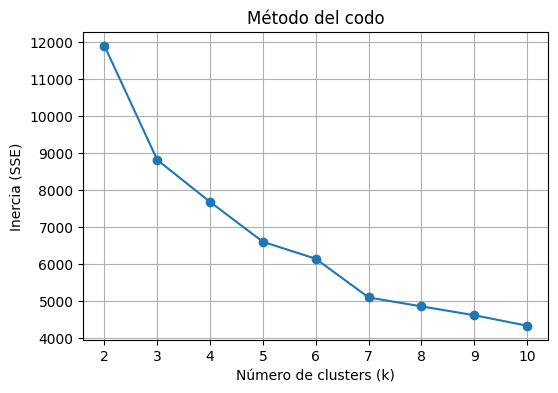

In [13]:
df = datos_ventas_stock_calendario_clean.drop(columns=['udsStock']).copy()


# Agregamos por producto: estadísticas básicas de demanda
features = (
    df.groupby('producto')
      .agg(
          mean_udsVenta=('udsVenta', 'mean'),
          std_udsVenta=('udsVenta', 'std'),
          max_udsVenta=('udsVenta', 'max'),
          total_udsVenta=('udsVenta', 'sum'),
          dias_con_datos=('udsVenta', 'size'),
          dias_con_venta=('udsVenta', lambda x: (x > 0).sum())
      )
      .reset_index()
)

# % de días con venta > 0
features['pct_dias_con_venta'] = features['dias_con_venta'] / features['dias_con_datos']

# Coeficiente de variación (std / media), controlando media = 0
features['cv_udsVenta'] = features.apply(
    lambda row: row['std_udsVenta'] / row['mean_udsVenta'] if row['mean_udsVenta'] > 0 else 0,
    axis=1
)

# Ventas medias por día de la semana (0-6) para cada producto
dow = (
    df.groupby(['producto', 'dia_semana'])['udsVenta']
      .mean()
      .unstack(fill_value=0)
)
dow.columns = [f'uds_dow_{int(c)}' for c in dow.columns]  # uds_dow_0 ... uds_dow_6

# Ventas medias por mes (1-12) para cada producto
meses = (
    df.groupby(['producto', 'mes'])['udsVenta']
      .mean()
      .unstack(fill_value=0)
)
meses.columns = [f'uds_mes_{int(c)}' for c in meses.columns]  # uds_mes_1 ... uds_mes_12

# Unimos todo en features
features = (
    features
    .merge(dow, on='producto', how='left')
    .merge(meses, on='producto', how='left')
)

# Rellenamos posibles NaN (por si algún producto no vendió en cierto mes/día)
features = features.fillna(0)

# Guardamos productos y nos quedamos solo con columnas numéricas
productos = features['producto']
X = features.drop(columns=['producto'])

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Método del codo
inertia = []
K_range = range(2, 11)  # por ejemplo de 2 a 10 clusters

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia (SSE)')
plt.title('Método del codo')
plt.grid(True)
plt.show()


In [14]:
k_optimo = 4 

features_kmeans = features.copy()

kmeans_final = KMeans(n_clusters=k_optimo, random_state=42, n_init='auto')
features_kmeans['cluster'] = kmeans_final.fit_predict(X_scaled)

# Asignar el cluster de cada producto a todas sus filas en el dataset diario
df_clusters = df.merge(
    features_kmeans[['producto', 'cluster']],
    on='producto',
    how='left'
)

datos_ventas_stock_calendario_kmeans = df_clusters



In [15]:
# Resumen por cluster
resumen_clusters = (
    features_kmeans
    .groupby('cluster')
    [['mean_udsVenta', 'std_udsVenta', 'total_udsVenta', 'pct_dias_con_venta', 'cv_udsVenta']]
    .mean()
)

print(resumen_clusters)

# Número de productos por cluster
print(features_kmeans['cluster'].value_counts())


         mean_udsVenta  std_udsVenta  total_udsVenta  pct_dias_con_venta  \
cluster                                                                    
0             1.687132      2.427295     1233.293750            0.474671   
1             0.825624      1.746113      603.530837            0.273233   
2             6.117419      5.653095     4471.833333            0.751596   
3             3.340465      3.848588     2441.879630            0.624791   

         cv_udsVenta  
cluster               
0           1.460132  
1           2.354679  
2           0.931746  
3           1.186852  
cluster
1    454
0    320
3    108
2     12
Name: count, dtype: int64


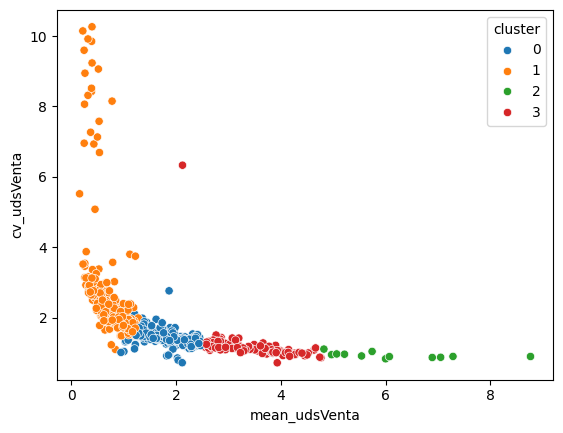

In [16]:
sns.scatterplot(
    data=features_kmeans,
    x='mean_udsVenta',
    y='cv_udsVenta',
    hue='cluster',
    palette='tab10'
)
plt.show()


Los cuatro clústeres identificados representan patrones de demanda bien diferenciados:

Cluster 0 — Rotación moderada y demanda estable
Demandan entre 1 y 2 unidades diarias con variabilidad baja-moderada.

Cluster 1 — Productos intermitentes de muy baja rotación
Representan artículos con venta esporádica y alta incertidumbre (CV elevado).

Cluster 2 — Alta rotación y demanda muy estable
Productos estratégicos cuya venta es constante y predecible.

Cluster 3 — Rotación media-alta y comportamiento estable
Patrones regulares con baja variabilidad, ligeramente por debajo del cluster 2.

## DBSCAN
Ideal si los datos tienen muchos outliers, clusters de formas no esféricas y densidades diferentes.

DBSCAN identifica puntos "densos" y separa los que no encajan → muy útil cuando hay productos con demanda muy irregular.


In [17]:
features_dbscan = features.copy()

X = StandardScaler().fit_transform(features)

dbscan = DBSCAN(eps=1.4, min_samples=5)
features_dbscan["cluster"] = dbscan.fit_predict(X)

features_dbscan


,producto,mean_udsVenta,std_udsVenta,max_udsVenta,total_udsVenta,dias_con_datos,dias_con_venta,pct_dias_con_venta,cv_udsVenta,uds_dow_0,...,uds_mes_4,uds_mes_5,uds_mes_6,uds_mes_7,uds_mes_8,uds_mes_9,uds_mes_10,uds_mes_11,uds_mes_12,cluster
0,1,8.763338,7.844207,49,6406,731,577,0.789330,0.895116,9.361905,...,6.583333,7.532258,11.800000,11.774194,10.548387,5.550000,8.790323,10.733333,9.403226,-1
1,2,7.284542,6.532617,42,5325,731,563,0.770178,0.896778,7.857143,...,5.850000,6.177419,8.566667,10.709677,7.467742,5.033333,6.483871,8.800000,8.419355,-1
2,3,5.214774,5.004283,26,3812,731,521,0.712722,0.959636,5.809524,...,4.566667,6.048387,5.750000,5.725806,5.419355,5.266667,5.532258,5.500000,4.645161,-1
3,4,3.017784,3.840442,26,2206,731,412,0.563611,1.272604,3.838095,...,2.683333,2.774194,3.800000,3.145161,2.806452,2.450000,3.225806,4.466667,2.806452,-1
4,5,3.770178,4.458544,26,2756,731,447,0.611491,1.182582,4.228571,...,2.816667,3.145161,5.516667,4.451613,3.354839,2.250000,3.854839,5.600000,3.645161,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
889,996,0.912449,1.775170,9,667,731,209,0.285910,1.945501,1.238095,...,1.350000,0.822581,1.450000,1.596774,0.967742,0.966667,1.000000,0.616667,0.548387,0
890,997,0.785226,1.514894,12,574,731,209,0.285910,1.929247,1.095238,...,0.766667,0.564516,0.416667,0.709677,0.693548,0.883333,1.209677,0.716667,1.225806,0
891,998,1.170999,1.869593,14,856,731,278,0.380301,1.596580,1.552381,...,1.666667,1.338710,1.016667,2.145161,1.145161,0.966667,1.338710,0.800000,0.935484,0
892,999,1.764706,2.766118,16,1290,731,314,0.429549,1.567467,2.104762,...,1.833333,1.725806,2.566667,3.725806,2.080645,1.383333,0.677419,1.116667,1.338710,-1


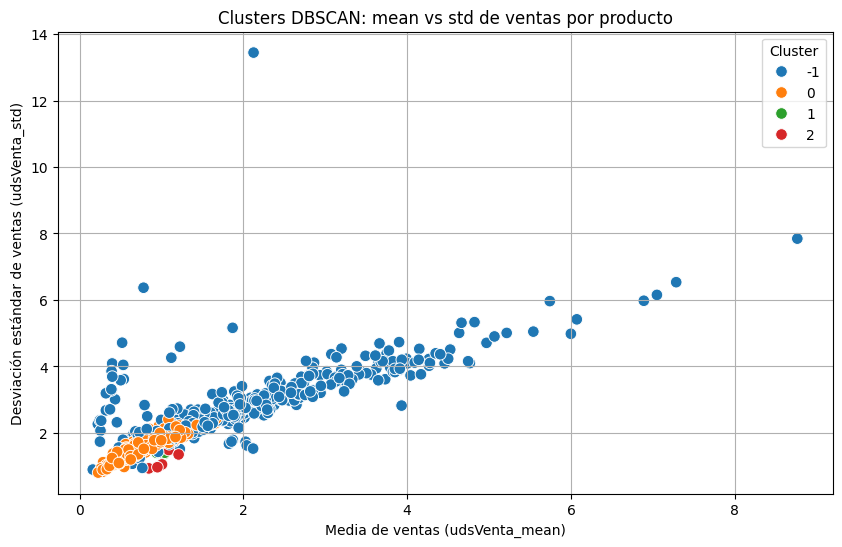

In [18]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=features_dbscan,
    x="mean_udsVenta",
    y="std_udsVenta",
    hue="cluster",
    palette="tab10",
    s=70
)

plt.title("Clusters DBSCAN: mean vs std de ventas por producto")
plt.xlabel("Media de ventas (udsVenta_mean)")
plt.ylabel("Desviación estándar de ventas (udsVenta_std)")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

Con únicamente media y desviación estándar de ventas, DBSCAN no puede identificar clusters significativos porque los productos presentan una estructura continua sin zonas de alta densidad aisladas.

El único cluster bien formado corresponde a productos de baja rotación y baja variabilidad, pero la mayoría de las referencias quedan clasificadas como ruido.

## Gaussian Mixture Models (GMM)

Ventaja clave: permite clusters elípticos, solapados y con diferente forma.
Los outliers no son un problema.



In [19]:
features_gmm = features.copy()

gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
labels_gmm = gmm.fit_predict(X)

features_gmm["cluster_gmm"] = labels_gmm


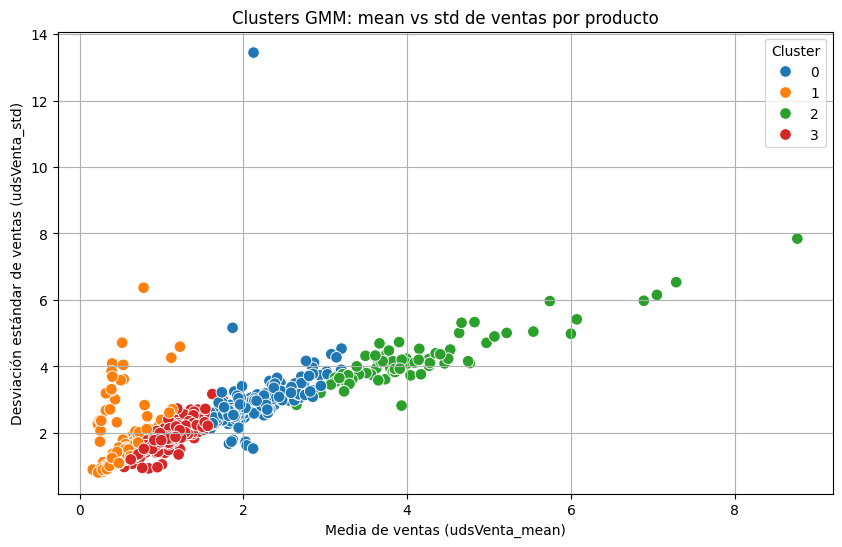

In [20]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=features_gmm,
    x="mean_udsVenta",
    y="std_udsVenta",
    hue="cluster_gmm",
    palette="tab10",
    s=70
)

plt.title("Clusters GMM: mean vs std de ventas por producto")
plt.xlabel("Media de ventas (udsVenta_mean)")
plt.ylabel("Desviación estándar de ventas (udsVenta_std)")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

Los productos se segmentan en 4 comportamientos claros:
- 0 - Demanda: Baja, Variabilidad: Estable, Tipo de producto: Lento pero predecible
- 1 - Demanda: Muy baja, Variabilidad: Alta, Tipo de producto: Irregular, riesgo de rotura
- 2 - Demanda: Alta, Variabilidad: Alta, Tipo de producto: Críticos, alto impacto
- 3 - Demanda: Media, Variabilidad: Media, Tipo de producto: Intermedios

## K-Medoids (PAM — Partitioning Around Medoids)

Ventaja clave: Robusto a outliers (mucho más que K-Means).

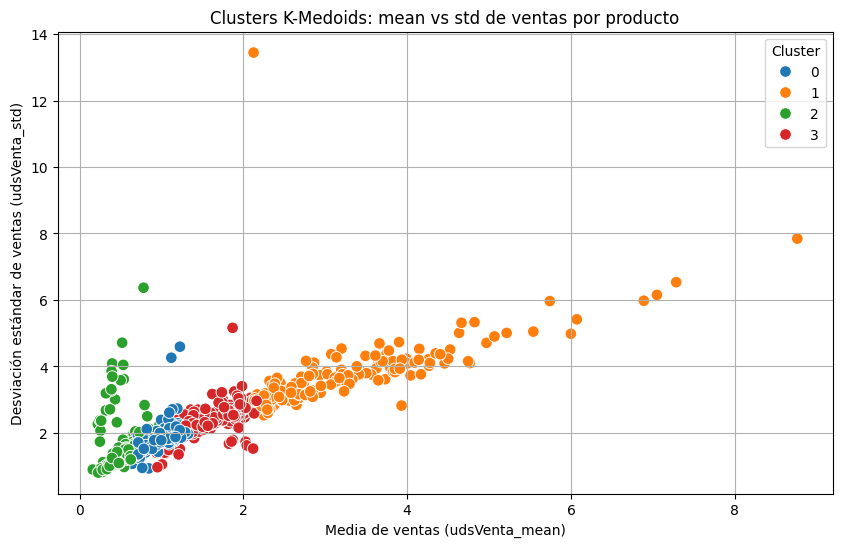

In [21]:
features_medoids = features.copy()
kmed = KMedoids(n_clusters=4, random_state=42)
labels_kmed = kmed.fit_predict(X)

features_medoids["cluster_kmed"] = labels_kmed

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=features_medoids,
    x="mean_udsVenta",
    y="std_udsVenta",
    hue="cluster_kmed",
    palette="tab10",
    s=70
)

plt.title("Clusters K-Medoids: mean vs std de ventas por producto")
plt.xlabel("Media de ventas (udsVenta_mean)")
plt.ylabel("Desviación estándar de ventas (udsVenta_std)")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()



Separa: 
Productos de alta rotación (verde)

Productos bajo-media rotación pero estables (azul)

Productos baja rotación pero muy volátiles (naranja)

Productos irregulares o atípicos (rojo)

Resultados muy parecidos a GMM.

# Entrenamiento de modelos

Vamos a realizar diferentes pruebas con diversos modelos para poder compararlos. Para ello, en primer lugar vamos a definir las métricas de comparación y definir una funcion para separar el dataset en entrenamiento y set.



In [22]:
df = datos_ventas_stock_calendario_clean.drop(columns=['udsStock']).copy()
# columnas:
# ['producto','idSecuencia','udsVenta','bolOpen','bolHoliday',
#  'isPromo','año','mes','dia','dia_semana','semana','semana_mes']

# --- métricas útiles ---
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def wmape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

def metricas(y_true, y_pred):
    return {
        "MSE": mean_squared_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred),
        "MAPE": mape(y_true, y_pred),
        "wMAPE": wmape(y_true, y_pred),
        "EVS": explained_variance_score(y_true, y_pred)
    }

# --- split temporal train/valid ---
def temporal_train_val_test_split(
    df: pd.DataFrame,
    date_col: str,
    group_col: Optional[Iterable[str]] = None
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Split temporal con rangos fijos:
      - Train: 2022-11-05 .. 2023-12-31
      - Val:   2024-01-01 .. 2024-05-31
      - Test:  2024-06-01 .. 2024-11-06

    Si `group_col` se especifica (string o iterable de strings), el split
    se aplica dentro de cada grupo: para cada grupo se toman las filas cuya
    fecha cae en los rangos anteriores y luego se concatenan todos los grupos.
    Devuelve (train, val, test) como DataFrames ordenados por `group_col` y `date_col`.

    Parámetros
    - df: DataFrame de entrada.
    - date_col: nombre de la columna de fecha en `df`.
    - group_col: None, nombre de columna (str) o lista/tupla de nombres para agrupar.

    Notas
    - La comparación de fechas es inclusiva en los extremos.
    - La función no rellena ni mueve filas fuera de los rangos especificados.
    """
    if date_col not in df.columns:
        raise KeyError(f"date_col '{date_col}' no existe en el DataFrame")

    work = df.copy()
    work[date_col] = pd.to_datetime(work[date_col])

    # Rangos fijos (dd-mm-yyyy interpretado como ISO yyyy-mm-dd)
    train_start = pd.Timestamp("2022-11-05")
    train_end = pd.Timestamp("2023-12-31")
    val_start = pd.Timestamp("2024-01-01")
    val_end = pd.Timestamp("2024-05-31")
    test_start = pd.Timestamp("2024-06-01")
    test_end = pd.Timestamp("2024-11-06")

    # Normalizar group_col a lista si viene como str
    if group_col is None:
        sort_cols: List[str] = [date_col]
        # Filtro global por fechas (rápido)
        mask_train = (work[date_col] >= train_start) & (work[date_col] <= train_end)
        mask_val = (work[date_col] >= val_start) & (work[date_col] <= val_end)
        mask_test = (work[date_col] >= test_start) & (work[date_col] <= test_end)

        train = work.loc[mask_train].sort_values(sort_cols)
        val = work.loc[mask_val].sort_values(sort_cols)
        test = work.loc[mask_test].sort_values(sort_cols)
        return train, val, test

    # Si se especifica group_col, convertir a lista de columnas
    if isinstance(group_col, str):
        group_cols = [group_col]
    else:
        group_cols = list(group_col)

    sort_cols = group_cols + [date_col]

    # Construimos listas por grupo para luego concatenar
    train_parts = []
    val_parts = []
    test_parts = []

    # Iterar por grupos: preserve groups even if algunos no tienen filas en un rango
    grouped = work.groupby(group_cols, dropna=False)
    for _, grp in grouped:
        # Asegurar tipo fecha ya convertido
        g = grp.copy()
        mask_train = (g[date_col] >= train_start) & (g[date_col] <= train_end)
        mask_val = (g[date_col] >= val_start) & (g[date_col] <= val_end)
        mask_test = (g[date_col] >= test_start) & (g[date_col] <= test_end)

        t = g.loc[mask_train]
        v = g.loc[mask_val]
        te = g.loc[mask_test]

        if not t.empty:
            train_parts.append(t.sort_values(sort_cols))
        if not v.empty:
            val_parts.append(v.sort_values(sort_cols))
        if not te.empty:
            test_parts.append(te.sort_values(sort_cols))

    # Concatenar manteniendo índices originales
    train = pd.concat(train_parts, axis=0) if train_parts else work.iloc[0:0]
    val = pd.concat(val_parts, axis=0) if val_parts else work.iloc[0:0]
    test = pd.concat(test_parts, axis=0) if test_parts else work.iloc[0:0]

    # Orden final por grupo + fecha
    train = train.sort_values(sort_cols)
    val = val.sort_values(sort_cols)
    test = test.sort_values(sort_cols)

    return train, val, test

In [23]:
datos_ventas_stock_calendario_clean.to_csv('Datos_Ventas_Stock_Calendario_Clean.csv', index=False)

## Modelo por producto, pero mismo modelo para todos los productos. Datos preprocesados y sin clustering

In [24]:
def naive_model(
    df_prod,
    date_col="idSecuencia"
):
    df_prod = df_prod.sort_values(date_col)
    train, val, test = temporal_train_val_test_split(
        df_prod,
        date_col=date_col,
        group_col=None,  # ya filtramos por producto antes
    )

    if len(train) == 0 or len(test) == 0:
        return None, None, train, val, test, None

    last_value = train['udsVenta'].iloc[-1]
    y_pred_val = np.full(len(val), last_value) if len(val) else np.array([])
    y_pred_test = np.full(len(test), last_value)

    res_val = metricas(val['udsVenta'], y_pred_val) if len(val) else None
    res_test = metricas(test['udsVenta'], y_pred_test)
    return res_test, res_val, train, val, test, y_pred_test

def naive_por_producto(df):
    resultados_test_globales = []
    resultados_val_globales = []
    y_true_test_global = []
    y_pred_test_global = []
    y_true_val_global = []
    y_pred_val_global = []
    preds_rows = []  # acumula dataset de test por producto

    for prod_id in df["producto"].unique():
        df_prod = df[df["producto"] == prod_id].copy()

        if len(df_prod) < 5:
            continue

        try:
            res_test, res_val, train, val, test, y_pred_test = naive_model(df_prod)

            if res_test is None or y_pred_test is None or len(test) == 0:
                continue

            resultados_test_globales.append({
                "producto": prod_id,
                "RMSE": res_test["RMSE"],
                "MAE": res_test["MAE"],
                "MAPE": res_test["MAPE"],
                "wMAPE": res_test["wMAPE"]
            })

            y_true_test_global.extend(test["udsVenta"].values)
            y_pred_test_global.extend(y_pred_test)

            # dataset de test con métricas por fila
            df_out = test[["producto", "idSecuencia", "udsVenta"]].copy()
            df_out["udsVenta_pred"] = y_pred_test
            df_out["abs_error"] = (df_out["udsVenta"] - df_out["udsVenta_pred"]).abs()
            df_out["sq_error"] = (df_out["udsVenta"] - df_out["udsVenta_pred"]) ** 2
            df_out["ape"] = df_out["abs_error"] / df_out["udsVenta"].replace(0, np.nan)
            for k, v in res_test.items():
                df_out[f"metric_{k}"] = v
            preds_rows.append(df_out)

            if res_val is not None and len(val) > 0:
                resultados_val_globales.append({
                    "producto": prod_id,
                    "RMSE": res_val["RMSE"],
                    "MAE": res_val["MAE"],
                    "MAPE": res_val["MAPE"],
                    "wMAPE": res_val["wMAPE"]
                })
                y_true_val_global.extend(val["udsVenta"].values)
                y_pred_val_global.extend(np.full(len(val), train["udsVenta"].iloc[-1]))

        except Exception as e:
            print(f"Error en producto {prod_id}: {e}")

    y_true_test_global = np.array(y_true_test_global)
    y_pred_test_global = np.array(y_pred_test_global)
    y_true_val_global = np.array(y_true_val_global)
    y_pred_val_global = np.array(y_pred_val_global)

    metricas_globales_test = None
    if len(y_true_test_global) > 0:
        metricas_globales_test = metricas(y_true_test_global, y_pred_test_global)
        print("Métricas globales modelo Naive (TEST):")
        for k, v in metricas_globales_test.items():
            print(f"{k}: {v:.4f}")
    else:
        print("No se han generado predicciones globales (listas vacías).")

    metricas_globales_val = None
    if len(y_true_val_global) > 0:
        metricas_globales_val = metricas(y_true_val_global, y_pred_val_global)
        print("Métricas globales modelo Naive (VALIDACIÓN):")
        for k, v in metricas_globales_val.items():
            print(f"{k}: {v:.4f}")
    else:
        print("No se han generado predicciones globales de validación (listas vacías).")

    df_preds_test = (
        pd.concat(preds_rows, ignore_index=True)
        if preds_rows
        else pd.DataFrame(
            columns=[
                "producto", "idSecuencia", "udsVenta", "udsVenta_pred",
                "abs_error", "sq_error", "ape",
                "metric_MSE", "metric_RMSE", "metric_MAE", "metric_MAPE",
                "metric_wMAPE", "metric_EVS"
            ]
        )
    )
    # ahora devuelve métricas + dataset de test con predicciones
    return metricas_globales_test, metricas_globales_val, df_preds_test


metricas_globales_test_naive, metricas_globales_val_naive, df_preds_test_naive = naive_por_producto(datos_ventas_stock_calendario_clean)

df_preds_test_naive.to_csv('Predicciones_Test_Naive_Clean.csv', index=False)

Métricas globales modelo Naive (TEST):
MSE: 33.5683
RMSE: 5.7938
MAE: 2.1063
MAPE: 91.0541
wMAPE: 1.4274
EVS: -3.8453
Métricas globales modelo Naive (VALIDACIÓN):
MSE: 32.8054
RMSE: 5.7276
MAE: 1.9994
MAPE: 90.1925
wMAPE: 1.4611
EVS: -4.2498


In [25]:
def moving_average_model(
    df_prod,
    window=7,
    date_col="idSecuencia"
):
    df_prod = df_prod.sort_values(date_col)
    train, val, test = temporal_train_val_test_split(
        df_prod,
        date_col=date_col,
        group_col=None,
    )

    if len(train) < window or len(test) == 0:
        return None, None, train, val, test, None, None

    mean_val = train['udsVenta'].tail(window).mean()
    y_pred_val = np.full(len(val), mean_val) if len(val) else np.array([])
    y_pred_test = np.full(len(test), mean_val)

    res_val = metricas(val['udsVenta'], y_pred_val) if len(val) else None
    res_test = metricas(test['udsVenta'], y_pred_test)
    return res_test, res_val, train, val, test, y_pred_test, y_pred_val

def moving_average_model_por_producto(df, window=7):
    resultados_test_globales = []
    resultados_val_globales = []
    y_true_test_global, y_pred_test_global = [], []
    y_true_val_global, y_pred_val_global = [], []
    preds_rows = []

    for prod_id in df["producto"].unique():
        df_prod = df[df["producto"] == prod_id].copy()

        try:
            res_test, res_val, train, val, test, y_pred_test, y_pred_val = moving_average_model(
                df_prod, window=window
            )

            if res_test is None or y_pred_test is None or len(test) == 0:
                continue

            resultados_test_globales.append({
                "producto": prod_id,
                "RMSE": res_test["RMSE"],
                "MAE": res_test["MAE"],
                "MAPE": res_test["MAPE"],
                "wMAPE": res_test["wMAPE"]
            })
            y_true_test_global.extend(test["udsVenta"].values)
            y_pred_test_global.extend(y_pred_test)

            # dataset de test con métricas por fila
            df_out = test[["producto", "idSecuencia", "udsVenta"]].copy()
            df_out["udsVenta_pred"] = y_pred_test
            df_out["abs_error"] = (df_out["udsVenta"] - df_out["udsVenta_pred"]).abs()
            df_out["sq_error"] = (df_out["udsVenta"] - df_out["udsVenta_pred"]) ** 2
            df_out["ape"] = df_out["abs_error"] / df_out["udsVenta"].replace(0, np.nan)
            for k, v in res_test.items():
                df_out[f"metric_{k}"] = v
            preds_rows.append(df_out)

            if res_val is not None and len(val) > 0:
                resultados_val_globales.append({
                    "producto": prod_id,
                    "RMSE": res_val["RMSE"],
                    "MAE": res_val["MAE"],
                    "MAPE": res_val["MAPE"],
                    "wMAPE": res_val["wMAPE"]
                })
                y_true_val_global.extend(val["udsVenta"].values)
                y_pred_val_global.extend(y_pred_val)

        except Exception as e:
            print(f"Error en producto {prod_id}: {e}")

    y_true_test_global = np.array(y_true_test_global)
    y_pred_test_global = np.array(y_pred_test_global)
    y_true_val_global = np.array(y_true_val_global)
    y_pred_val_global = np.array(y_pred_val_global)

    metricas_globales_test = None
    if len(y_true_test_global) > 0:
        metricas_globales_test = metricas(y_true_test_global, y_pred_test_global)
        print("Métricas globales modelo media móvil (TEST):")
        for k, v in metricas_globales_test.items():
            print(f"{k}: {v:.4f}")
    else:
        print("No se han generado predicciones globales (listas vacías).")

    metricas_globales_val = None
    if len(y_true_val_global) > 0:
        metricas_globales_val = metricas(y_true_val_global, y_pred_val_global)
        print("Métricas globales modelo media móvil (VALIDACIÓN):")
        for k, v in metricas_globales_val.items():
            print(f"{k}: {v:.4f}")
    else:
        print("No se han generado predicciones globales de validación (listas vacías).")

    df_preds_test = (
        pd.concat(preds_rows, ignore_index=True)
        if preds_rows
        else pd.DataFrame(
            columns=[
                "producto", "idSecuencia", "udsVenta", "udsVenta_pred",
                "abs_error", "sq_error", "ape",
                "metric_MSE", "metric_RMSE", "metric_MAE", "metric_MAPE",
                "metric_wMAPE", "metric_EVS"
            ]
        )
    )

    # devuelve métricas y dataset de test con predicciones
    return metricas_globales_test, metricas_globales_val, df_preds_test


metricas_globales_test_moving_average, metricas_globales_val_moving_average, df_preds_test_moving_average = moving_average_model_por_producto(datos_ventas_stock_calendario_clean)

df_preds_test_moving_average.to_csv('Predicciones_Test_Moving_Average_Clean.csv', index=False)

Métricas globales modelo media móvil (TEST):
MSE: 7.6372
RMSE: 2.7635
MAE: 1.8130
MAPE: 61.1949
wMAPE: 1.2286
EVS: -0.1072
Métricas globales modelo media móvil (VALIDACIÓN):
MSE: 6.7152
RMSE: 2.5914
MAE: 1.7241
MAPE: 58.9367
wMAPE: 1.2599
EVS: -0.0685


In [26]:
def sarima_model_producto(
    df_prod,
    order=(1,1,1),
    seasonal_order=(0,1,1,7),
    min_len=30,
    date_col="idSecuencia"
):
    """
    Ajusta un SARIMA a la serie de un producto y devuelve m?tricas de test/val.
    """
    df_prod = df_prod.sort_values(date_col)

    if len(df_prod) < min_len:
        return None, None, df_prod, df_prod.iloc[0:0], df_prod.iloc[0:0], None, None

    train, val, test = temporal_train_val_test_split(
        df_prod,
        date_col=date_col,
        group_col=None,
    )

    if len(train) < min_len or len(test) == 0:
        return None, None, train, val, test, None, None

    y_train = train['udsVenta']
    y_val = val['udsVenta']
    y_test = test['udsVenta']

    try:
        model = SARIMAX(
            y_train,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        res = model.fit(disp=False)

        y_pred_test = res.forecast(steps=len(y_test))
        res_test = metricas(y_test, y_pred_test)

        y_pred_val = None
        res_val = None
        if len(y_val) > 0:
            y_pred_val = res.get_prediction(start=len(y_train), end=len(y_train)+len(y_val)-1).predicted_mean
            res_val = metricas(y_val, y_pred_val)

        return res_test, res_val, train, val, test, np.array(y_pred_test), np.array(y_pred_val) if y_pred_val is not None else None

    except Exception as e:
        # si falla el ajuste, devolvemos None
        # print(f"Error SARIMA en producto: {e}")
        return None, None, train, val, test, None, None

def sarima_model_por_producto(df):
    resultados_test_globales_sarima = []
    resultados_val_globales_sarima = []
    y_true_test_global_sarima, y_pred_test_global_sarima = [], []
    y_true_val_global_sarima, y_pred_val_global_sarima = [], []
    preds_rows = []

    for prod_id in df['producto'].unique():
        print(f"Procesando producto SARIMA: {prod_id}")
        df_prod = df[df['producto'] == prod_id].copy()

        try:
            res_test, res_val, train, val, test, y_pred_test, y_pred_val = sarima_model_producto(df_prod)

            if res_test is None or y_pred_test is None or len(test) == 0:
                continue

            resultados_test_globales_sarima.append({
                "producto": prod_id,
                "RMSE": res_test["RMSE"],
                "MAE": res_test["MAE"],
                "MAPE": res_test["MAPE"],
                "wMAPE": res_test["wMAPE"]
            })

            y_true_test_global_sarima.extend(test['udsVenta'].values)
            y_pred_test_global_sarima.extend(y_pred_test)

            df_out = test[["producto", "idSecuencia", "udsVenta"]].copy()
            df_out["udsVenta_pred"] = y_pred_test
            df_out["abs_error"] = (df_out["udsVenta"] - df_out["udsVenta_pred"]).abs()
            df_out["sq_error"] = (df_out["udsVenta"] - df_out["udsVenta_pred"]) ** 2
            df_out["ape"] = df_out["abs_error"] / df_out["udsVenta"].replace(0, np.nan)
            for k, v in res_test.items():
                df_out[f"metric_{k}"] = v
            preds_rows.append(df_out)

            if res_val is not None and len(val) > 0 and y_pred_val is not None:
                resultados_val_globales_sarima.append({
                    "producto": prod_id,
                    "RMSE": res_val["RMSE"],
                    "MAE": res_val["MAE"],
                    "MAPE": res_val["MAPE"],
                    "wMAPE": res_val["wMAPE"]
                })
                y_true_val_global_sarima.extend(val['udsVenta'].values)
                y_pred_val_global_sarima.extend(y_pred_val)

        except Exception as e:
            print(f"Error en producto {prod_id}: {e}")

    y_true_test_global_sarima = np.array(y_true_test_global_sarima)
    y_pred_test_global_sarima = np.array(y_pred_test_global_sarima)
    y_true_val_global_sarima = np.array(y_true_val_global_sarima)
    y_pred_val_global_sarima = np.array(y_pred_val_global_sarima)

    if len(y_true_test_global_sarima) == 0:
        print("No se han generado predicciones globales SARIMA (test).")
        metricas_globales_test = None
    else:
        metricas_globales_test = metricas(y_true_test_global_sarima, y_pred_test_global_sarima)
        print("Métricas globales SARIMA (TEST):")
        for k, v in metricas_globales_test.items():
            print(f"{k}: {v:.4f}")

    if len(y_true_val_global_sarima) == 0:
        print("No se han generado predicciones globales SARIMA (validación).")
        metricas_globales_val = None
    else:
        metricas_globales_val = metricas(y_true_val_global_sarima, y_pred_val_global_sarima)
        print("Métricas globales SARIMA (VALIDACIÓN):")
        for k, v in metricas_globales_val.items():
            print(f"{k}: {v:.4f}")

    df_preds_test = (
        pd.concat(preds_rows, ignore_index=True)
        if preds_rows
        else pd.DataFrame(
            columns=[
                "producto", "idSecuencia", "udsVenta", "udsVenta_pred",
                "abs_error", "sq_error", "ape",
                "metric_MSE", "metric_RMSE", "metric_MAE", "metric_MAPE",
                "metric_wMAPE", "metric_EVS"
            ]
        )
    )

    return metricas_globales_test, metricas_globales_val, df_preds_test



metricas_globales_test_sarima_clean, metricas_globales_val_sarima_clean, df_preds_test_sarima = sarima_model_por_producto(datos_ventas_stock_calendario_clean)

df_preds_test_sarima.to_csv('Predicciones_Test_SARIMA_Clean.csv', index=False)

Procesando producto SARIMA: 1
Procesando producto SARIMA: 2
Procesando producto SARIMA: 3
Procesando producto SARIMA: 4
Procesando producto SARIMA: 5
Procesando producto SARIMA: 6
Procesando producto SARIMA: 7
Procesando producto SARIMA: 8
Procesando producto SARIMA: 9
Procesando producto SARIMA: 10
Procesando producto SARIMA: 12
Procesando producto SARIMA: 13
Procesando producto SARIMA: 14
Procesando producto SARIMA: 15
Procesando producto SARIMA: 16
Procesando producto SARIMA: 17
Procesando producto SARIMA: 18
Procesando producto SARIMA: 19
Procesando producto SARIMA: 20
Procesando producto SARIMA: 21
Procesando producto SARIMA: 22
Procesando producto SARIMA: 23
Procesando producto SARIMA: 24
Procesando producto SARIMA: 25
Procesando producto SARIMA: 26
Procesando producto SARIMA: 27
Procesando producto SARIMA: 28
Procesando producto SARIMA: 29
Procesando producto SARIMA: 30
Procesando producto SARIMA: 31
Procesando producto SARIMA: 32
Procesando producto SARIMA: 33
Procesando produc

In [27]:
def holtwinters_model_producto(
    df_prod,
    seasonal_periods=7,
    trend='add',
    seasonal='add',
    min_len=30,
    date_col="idSecuencia"
):
    """Ajusta Holt-Winters y devuelve metricas de test y validacion."""
    df_prod = df_prod.sort_values(date_col)

    if len(df_prod) < min_len:
        return None, None, df_prod, df_prod.iloc[0:0], df_prod.iloc[0:0], None, None

    train, val, test = temporal_train_val_test_split(
        df_prod,
        date_col=date_col,
        group_col=None,
    )

    if len(train) < min_len or len(test) == 0:
        return None, None, train, val, test, None, None

    y_train = train['udsVenta']
    y_val = val['udsVenta']
    y_test = test['udsVenta']

    try:
        model = ExponentialSmoothing(
            y_train,
            trend=trend,
            seasonal=seasonal,
            seasonal_periods=seasonal_periods
        )
        res = model.fit(optimized=True)

        y_pred_test = res.forecast(len(y_test))
        res_test = metricas(y_test, y_pred_test)

        y_pred_val = np.array([])
        res_val = None
        if len(y_val) > 0:
            y_pred_val = res.forecast(len(y_val))
            res_val = metricas(y_val, y_pred_val)

        return res_test, res_val, train, val, test, np.array(y_pred_test), np.array(y_pred_val)

    except Exception:
        return None, None, train, val, test, None, None

def holtwinters_model_por_producto(df):
    resultados_test_globales_hw = []
    resultados_val_globales_hw = []
    y_true_test_global_hw, y_pred_test_global_hw = [], []
    y_true_val_global_hw, y_pred_val_global_hw = [], []
    preds_rows = []

    for prod_id in df['producto'].unique():
        print(f"Procesando producto {prod_id} con Holt-Winters...")
        df_prod = df[df['producto'] == prod_id].copy()

        if len(df_prod) < 30:
            continue

        try:
            res_test, res_val, train, val, test, y_pred_test, y_pred_val = holtwinters_model_producto(df_prod)

            if res_test is None or y_pred_test is None or len(test) == 0:
                continue

            resultados_test_globales_hw.append({
                "producto": prod_id,
                "RMSE": res_test["RMSE"],
                "MAE": res_test["MAE"],
                "MAPE": res_test["MAPE"],
                "wMAPE": res_test["wMAPE"]
            })

            y_true_test_global_hw.extend(test['udsVenta'].values)
            y_pred_test_global_hw.extend(y_pred_test)

            df_out = test[["producto", "idSecuencia", "udsVenta"]].copy()
            df_out["udsVenta_pred"] = y_pred_test
            df_out["abs_error"] = (df_out["udsVenta"] - df_out["udsVenta_pred"]).abs()
            df_out["sq_error"] = (df_out["udsVenta"] - df_out["udsVenta_pred"]) ** 2
            df_out["ape"] = df_out["abs_error"] / df_out["udsVenta"].replace(0, np.nan)
            for k, v in res_test.items():
                df_out[f"metric_{k}"] = v
            preds_rows.append(df_out)

            if res_val is not None and len(val) > 0:
                resultados_val_globales_hw.append({
                    "producto": prod_id,
                    "RMSE": res_val["RMSE"],
                    "MAE": res_val["MAE"],
                    "MAPE": res_val["MAPE"],
                    "wMAPE": res_val["wMAPE"]
                })
                y_true_val_global_hw.extend(val['udsVenta'].values)
                y_pred_val_global_hw.extend(y_pred_val)

        except Exception as e:
            print(f"Error Holt-Winters en producto {prod_id}: {e}")

    y_true_test_global_hw = np.array(y_true_test_global_hw)
    y_pred_test_global_hw = np.array(y_pred_test_global_hw)
    y_true_val_global_hw = np.array(y_true_val_global_hw)
    y_pred_val_global_hw = np.array(y_pred_val_global_hw)

    if len(y_true_test_global_hw) == 0:
        print("No se han generado predicciones globales Holt-Winters (test).")
        metricas_globales_test = None
    else:
        metricas_globales_test = metricas(y_true_test_global_hw, y_pred_test_global_hw)
        print("Metricas globales Holt-Winters (TEST):")
        for k, v in metricas_globales_test.items():
            print(f"{k}: {v:.4f}")

    if len(y_true_val_global_hw) == 0:
        print("No se han generado predicciones globales Holt-Winters (validacion).")
        metricas_globales_val = None
    else:
        metricas_globales_val = metricas(y_true_val_global_hw, y_pred_val_global_hw)
        print("Metricas globales Holt-Winters (VALIDACION):")
        for k, v in metricas_globales_val.items():
            print(f"{k}: {v:.4f}")

    df_preds_test = (
        pd.concat(preds_rows, ignore_index=True)
        if preds_rows
        else pd.DataFrame(
            columns=[
                "producto", "idSecuencia", "udsVenta", "udsVenta_pred",
                "abs_error", "sq_error", "ape",
                "metric_MSE", "metric_RMSE", "metric_MAE", "metric_MAPE",
                "metric_wMAPE", "metric_EVS"
            ]
        )
    )

    return metricas_globales_test, metricas_globales_val, df_preds_test


metricas_globales_test_hw, metricas_globales_val_hw, df_preds_test_hw = holtwinters_model_por_producto(datos_ventas_stock_calendario_clean)
df_preds_test_hw.to_csv('Predicciones_Test_HoltWinters_Clean.csv', index=False)



Procesando producto 1 con Holt-Winters...
Procesando producto 2 con Holt-Winters...
Procesando producto 3 con Holt-Winters...
Procesando producto 4 con Holt-Winters...
Procesando producto 5 con Holt-Winters...
Procesando producto 6 con Holt-Winters...
Procesando producto 7 con Holt-Winters...
Procesando producto 8 con Holt-Winters...
Procesando producto 9 con Holt-Winters...
Procesando producto 10 con Holt-Winters...
Procesando producto 12 con Holt-Winters...
Procesando producto 13 con Holt-Winters...
Procesando producto 14 con Holt-Winters...
Procesando producto 15 con Holt-Winters...
Procesando producto 16 con Holt-Winters...
Procesando producto 17 con Holt-Winters...
Procesando producto 18 con Holt-Winters...
Procesando producto 19 con Holt-Winters...
Procesando producto 20 con Holt-Winters...
Procesando producto 21 con Holt-Winters...
Procesando producto 22 con Holt-Winters...
Procesando producto 23 con Holt-Winters...
Procesando producto 24 con Holt-Winters...
Procesando producto 

In [28]:
def preparar_features_producto(df_prod, max_lag=7):
    """
    Crea lags por producto y elimina filas con NaN generados.
    """
    g = df_prod.sort_values("idSecuencia").copy()
    for lag in range(1, max_lag + 1):
        g[f"lag_{lag}"] = g["udsVenta"].shift(lag)
    # features basicas de calendario + lags
    feature_cols = [
        "dia_semana","mes","semana","semana_mes",
        "bolOpen","bolHoliday","isPromo"
    ] + [f"lag_{i}" for i in range(1, max_lag + 1)]
    g = g.dropna()
    return g, feature_cols


def rf_model_producto(
    df_prod,
    date_col="idSecuencia",
    max_lag=7,
    rf_params=None,
    param_grid=None,          # dict con la rejilla
    metric_opt="RMSE"        # métrica a minimizar en la búsqueda
):
    df_feat, feature_cols = preparar_features_producto(df_prod, max_lag=max_lag)
    if len(df_feat) < (max_lag + 1):
        return None, None, df_feat, df_feat.iloc[0:0], df_feat.iloc[0:0], None, None

    train, val, test = temporal_train_val_test_split(
        df_feat,
        date_col=date_col,
        group_col=None,
    )

    if len(train) == 0 or len(test) == 0:
        return None, None, train, val, test, None, None

    X_train, y_train = train[feature_cols], train["udsVenta"]
    X_val, y_val = val[feature_cols], val["udsVenta"]
    X_test, y_test = test[feature_cols], test["udsVenta"]

    base_params = {"n_estimators": 200, "random_state": 42, "n_jobs": -1}
    if rf_params:
        base_params.update(rf_params)

    # Grid search sobre validación (o sobre train si no hay val)
    best_params = base_params.copy()
    if param_grid:
        search_target_X = X_val if len(X_val) > 0 else X_train
        search_target_y = y_val if len(X_val) > 0 else y_train

        best_score = np.inf
        for candidate in ParameterGrid(param_grid):
            trial_params = {**base_params, **candidate}
            trial_model = RandomForestRegressor(**trial_params)
            trial_model.fit(X_train, y_train)

            preds = trial_model.predict(search_target_X)
            score = metricas(search_target_y, preds)[metric_opt]
            if score < best_score:
                best_score = score
                best_params = trial_params

    # Entrenamos modelo final con los mejores params
    model = RandomForestRegressor(**best_params)
    model.fit(pd.concat([train, val])[feature_cols], pd.concat([train, val])["udsVenta"])

    y_pred_test = model.predict(X_test)
    res_test = metricas(y_test, y_pred_test)

    y_pred_val = np.array([])
    res_val = None
    if len(X_val) > 0:
        y_pred_val = model.predict(X_val)
        res_val = metricas(y_val, y_pred_val)

    return res_test, res_val, train, val, test, y_pred_test, y_pred_val

def rf_model_por_producto(df, rf_params=None, param_grid=None, metric_opt="wMAPE"):
    resultados_test_rf, resultados_val_rf = [], []
    y_true_test_rf, y_pred_test_rf = [], []
    y_true_val_rf, y_pred_val_rf = [], []
    preds_rows = []

    for prod_id in df["producto"].unique():
        print(f"Procesando producto {prod_id} con Random Forest con best params...")
        df_prod = df[df["producto"] == prod_id].copy()
        if len(df_prod) < 10:
            continue

        try:
            res_test, res_val, train, val, test, y_pred_test, y_pred_val = rf_model_producto(
                df_prod,
                rf_params=rf_params,
                param_grid=param_grid,
                metric_opt=metric_opt,
            )
            if res_test is None or y_pred_test is None or len(test) == 0:
                continue
            
            # dataset de test por producto con errores por fila y métricas del producto

            df_out = test[["producto", "idSecuencia", "udsVenta"]].copy()
            df_out["udsVenta_pred"] = y_pred_test
            df_out["abs_error"] = (df_out["udsVenta"] - df_out["udsVenta_pred"]).abs()
            df_out["sq_error"] = (df_out["udsVenta"] - df_out["udsVenta_pred"]) ** 2
            df_out["ape"] = df_out["abs_error"] / df_out["udsVenta"].replace(0, np.nan)
            for k, v in res_test.items():
                df_out[f"metric_{k}"] = v
            preds_rows.append(df_out)

            resultados_test_rf.append({**{"producto": prod_id}, **res_test})
            y_true_test_rf.extend(test["udsVenta"].values)
            y_pred_test_rf.extend(y_pred_test)

            if res_val is not None and len(y_pred_val) > 0:
                resultados_val_rf.append({**{"producto": prod_id}, **res_val})
                y_true_val_rf.extend(val["udsVenta"].values)
                y_pred_val_rf.extend(y_pred_val)

        except Exception as e:
            print(f"Error RF en producto {prod_id}: {e}")

    # Métricas globales
    y_true_test_rf = np.array(y_true_test_rf)
    y_pred_test_rf = np.array(y_pred_test_rf)
    if len(y_true_test_rf) == 0:
        print("No se han generado predicciones globales RF (test).")
    else:
        metricas_test_global = metricas(y_true_test_rf, y_pred_test_rf)
        print("Metricas globales RF (TEST):")
        for k, v in metricas_test_global.items():
            print(f"{k}: {v:.4f}")

    y_true_val_rf = np.array(y_true_val_rf)
    y_pred_val_rf = np.array(y_pred_val_rf)
    if len(y_true_val_rf) == 0:
        print("No se han generado predicciones globales RF (validacion).")
    else:
        metricas_val_global = metricas(y_true_val_rf, y_pred_val_rf)
        print("Metricas globales RF (VALIDACION):")
        for k, v in metricas_val_global.items():
            print(f"{k}: {v:.4f}")
    df_preds_test = (
        pd.concat(preds_rows, ignore_index=True)
        if preds_rows
        else pd.DataFrame(
            columns=[
                "producto", "idSecuencia", "udsVenta", "udsVenta_pred",
                "abs_error", "sq_error", "ape",
                "metric_MSE", "metric_RMSE", "metric_MAE", "metric_MAPE",
                "metric_wMAPE", "metric_EVS"
            ]
        )
    )
    return metricas_test_global, metricas_val_global, df_preds_test

param_grid = {
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt", "log2"],
    "n_estimators": [200, 400],
}



In [35]:
metricas_globales_test_rf, metricas_globales_val_rf, df_preds_test_rf = rf_model_por_producto(datos_ventas_stock_calendario_clean, param_grid=param_grid, metric_opt="RMSE")
df_preds_test_rf.to_csv('Predicciones_Test_Random_Forest_Clean.csv', index=False)


Procesando producto 1 con Random Forest con best params...
Procesando producto 2 con Random Forest con best params...
Procesando producto 3 con Random Forest con best params...
Procesando producto 4 con Random Forest con best params...
Procesando producto 5 con Random Forest con best params...
Procesando producto 6 con Random Forest con best params...
Procesando producto 7 con Random Forest con best params...
Procesando producto 8 con Random Forest con best params...
Procesando producto 9 con Random Forest con best params...
Procesando producto 10 con Random Forest con best params...
Procesando producto 12 con Random Forest con best params...
Procesando producto 13 con Random Forest con best params...
Procesando producto 14 con Random Forest con best params...
Procesando producto 15 con Random Forest con best params...
Procesando producto 16 con Random Forest con best params...
Procesando producto 17 con Random Forest con best params...
Procesando producto 18 con Random Forest con best

In [36]:
def xgb_model_producto(
    df_prod,
    date_col="idSecuencia",
    max_lag=7,
    param_grid=None,
    metric_opt="RMSE",  # RMSE | MAE | MAPE | wMAPE
):
    df_feat, feature_cols = preparar_features_producto(df_prod, max_lag=max_lag)
    if len(df_feat) < (max_lag + 1):
        return None, None, df_feat, df_feat.iloc[0:0], df_feat.iloc[0:0], None, None

    train, val, test = temporal_train_val_test_split(
        df_feat,
        date_col=date_col,
        group_col=None,
    )

    if len(train) == 0 or len(test) == 0:
        return None, None, train, val, test, None, None

    X_train, y_train = train[feature_cols], train["udsVenta"]
    X_val, y_val = val[feature_cols], val["udsVenta"]
    X_test, y_test = test[feature_cols], test["udsVenta"]

    if param_grid is None:
        param_grid = {
            "n_estimators": [300, 600],
            "max_depth": [3, 6, 8],
            "learning_rate": [0.05, 0.1],
            "subsample": [0.7, 1.0],
            "colsample_bytree": [0.7, 1.0],
            "min_child_weight": [1, 5],
        }

    def scorer_func(y_true, y_pred):
        return metricas(y_true, y_pred)[metric_opt]

    xgb_scorer = make_scorer(lambda yt, yp: -scorer_func(yt, yp))  # minimizar

    try:
        cv = TimeSeriesSplit(n_splits=3) if len(train) >= 30 else 2
        gs = GridSearchCV(
            XGBRegressor(
                objective="reg:squarederror",
                random_state=42,
                n_jobs=-1,
                tree_method="hist",
            ),
            param_grid=param_grid,
            scoring=xgb_scorer,
            cv=cv,
            n_jobs=-1,
        )
        gs.fit(X_train, y_train)
        best_xgb = gs.best_estimator_

        # reentrenar en train+val y predecir test
        X_trainval = pd.concat([X_train, X_val])
        y_trainval = pd.concat([y_train, y_val]) if len(val) else y_train
        best_xgb.fit(X_trainval, y_trainval, verbose=False)

        y_pred_test = best_xgb.predict(X_test)
        res_test = metricas(y_test, y_pred_test)

        y_pred_val = best_xgb.predict(X_val) if len(val) else np.array([])
        res_val = metricas(y_val, y_pred_val) if len(val) else None

        return res_test, res_val, train, val, test, y_pred_test, y_pred_val, gs.best_params_

    except Exception as e:
        print(f"Error XGB en producto: {e}")
        return None, None, train, val, test, None, None, None


def xgb_model_por_producto(df, param_grid=None, metric_opt="RMSE"):
    resultados_test_xgb = []
    resultados_val_xgb = []
    y_true_test_xgb, y_pred_test_xgb = [], []
    y_true_val_xgb, y_pred_val_xgb = [], []
    preds_rows = []

    for prod_id in df["producto"].unique():
        print(f"Procesando producto {prod_id} con XGB...")
        df_prod = df[df["producto"] == prod_id].copy()

        if len(df_prod) < 10:
            continue

        try:
            res_test, res_val, train, val, test, y_pred_test, y_pred_val, best_params = xgb_model_producto(
                df_prod,
                param_grid=param_grid,
                metric_opt=metric_opt,
            )

            if res_test is None or y_pred_test is None or len(test) == 0:
                continue

            resultados_test_xgb.append({
                "producto": prod_id,
                "RMSE": res_test["RMSE"],
                "MAE": res_test["MAE"],
                "MAPE": res_test["MAPE"],
                "wMAPE": res_test["wMAPE"],
                "best_params": best_params,
            })
            y_true_test_xgb.extend(test["udsVenta"].values)
            y_pred_test_xgb.extend(y_pred_test)

            df_out = test[["producto", "idSecuencia", "udsVenta"]].copy()
            df_out["udsVenta_pred"] = y_pred_test
            df_out["abs_error"] = (df_out["udsVenta"] - df_out["udsVenta_pred"]).abs()
            df_out["sq_error"] = (df_out["udsVenta"] - df_out["udsVenta_pred"]) ** 2
            df_out["ape"] = df_out["abs_error"] / df_out["udsVenta"].replace(0, np.nan)
            for k, v in res_test.items():
                df_out[f"metric_{k}"] = v
            preds_rows.append(df_out)

            if res_val is not None and len(y_pred_val) > 0:
                resultados_val_xgb.append({
                    "producto": prod_id,
                    "RMSE": res_val["RMSE"],
                    "MAE": res_val["MAE"],
                    "MAPE": res_val["MAPE"],
                    "wMAPE": res_val["wMAPE"],
                    "best_params": best_params,
                })
                y_true_val_xgb.extend(val["udsVenta"].values)
                y_pred_val_xgb.extend(y_pred_val)

        except Exception as e:
            print(f"Error XGB en producto {prod_id}: {e}")

    y_true_test_xgb = np.array(y_true_test_xgb)
    y_pred_test_xgb = np.array(y_pred_test_xgb)
    y_true_val_xgb = np.array(y_true_val_xgb)
    y_pred_val_xgb = np.array(y_pred_val_xgb)

    if len(y_true_test_xgb) == 0:
        print("No se han generado predicciones globales XGB (test).")
        metricas_test_global = None
    else:
        metricas_test_global = metricas(y_true_test_xgb, y_pred_test_xgb)
        print("Metricas globales XGB (TEST):")
        for k, v in metricas_test_global.items():
            print(f"{k}: {v:.4f}")

    if len(y_true_val_xgb) == 0:
        print("No se han generado predicciones globales XGB (validacion).")
        metricas_val_global = None
    else:
        metricas_val_global = metricas(y_true_val_xgb, y_pred_val_xgb)
        print("Metricas globales XGB (VALIDACION):")
        for k, v in metricas_val_global.items():
            print(f"{k}: {v:.4f}")

    df_preds_test = (
        pd.concat(preds_rows, ignore_index=True)
        if preds_rows
        else pd.DataFrame(
            columns=[
                "producto", "idSecuencia", "udsVenta", "udsVenta_pred",
                "abs_error", "sq_error", "ape",
                "metric_MSE", "metric_RMSE", "metric_MAE", "metric_MAPE",
                "metric_wMAPE", "metric_EVS"
            ]
        )
    )

    return metricas_test_global, metricas_val_global, df_preds_test
metricas_globales_test_xgb, metricas_globales_val_xgb, df_preds_test_xgb = xgb_model_por_producto(datos_ventas_stock_calendario_clean, metric_opt="RMSE")
df_preds_test_xgb.to_csv('Predicciones_Test_XGB_Clean.csv', index=False)

Procesando producto 1 con XGB...
Procesando producto 2 con XGB...
Procesando producto 3 con XGB...
Procesando producto 4 con XGB...
Procesando producto 5 con XGB...
Procesando producto 6 con XGB...
Procesando producto 7 con XGB...
Procesando producto 8 con XGB...
Procesando producto 9 con XGB...
Procesando producto 10 con XGB...
Procesando producto 12 con XGB...
Procesando producto 13 con XGB...
Procesando producto 14 con XGB...
Procesando producto 15 con XGB...
Procesando producto 16 con XGB...
Procesando producto 17 con XGB...
Procesando producto 18 con XGB...
Procesando producto 19 con XGB...
Procesando producto 20 con XGB...
Procesando producto 21 con XGB...
Procesando producto 22 con XGB...
Procesando producto 23 con XGB...
Procesando producto 24 con XGB...
Procesando producto 25 con XGB...
Procesando producto 26 con XGB...
Procesando producto 27 con XGB...
Procesando producto 28 con XGB...
Procesando producto 29 con XGB...
Procesando producto 30 con XGB...
Procesando producto 31 

In [37]:
def mlp_model_producto(
    df_prod,
    date_col="idSecuencia",
    max_lag=7,
    param_grid=None,
    metric_opt="RMSE",  # RMSE | MAE | MAPE | wMAPE
):
    df_feat, feature_cols = preparar_features_producto(df_prod, max_lag=max_lag)
    if len(df_feat) < (max_lag + 1):
        return None, None, df_feat, df_feat.iloc[0:0], df_feat.iloc[0:0], None, None, None

    train, val, test = temporal_train_val_test_split(
        df_feat,
        date_col=date_col,
        group_col=None,
    )
    if len(train) == 0 or len(test) == 0:
        return None, None, train, val, test, None, None, None

    X_train, y_train = train[feature_cols], train["udsVenta"]
    X_val, y_val = val[feature_cols], val["udsVenta"]
    X_test, y_test = test[feature_cols], test["udsVenta"]

    if param_grid is None:
        param_grid = {
            "mlp__hidden_layer_sizes": [(64, 32), (128, 64)],
            "mlp__activation": ["relu", "tanh"],
            "mlp__alpha": [1e-4, 1e-3],
            "mlp__learning_rate_init": [0.001, 0.01],
        }

    def scorer_func(y_true, y_pred):
        return metricas(y_true, y_pred)[metric_opt]

    mlp_scorer = make_scorer(lambda yt, yp: -scorer_func(yt, yp))

    try:
        cv = TimeSeriesSplit(n_splits=3) if len(train) >= 30 else 2
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("mlp", MLPRegressor(max_iter=400, random_state=42)),
        ])
        gs = GridSearchCV(
            pipe,
            param_grid=param_grid,
            scoring=mlp_scorer,
            cv=cv,
            n_jobs=-1,
        )
        gs.fit(X_train, y_train)
        best_mlp = gs.best_estimator_

        # reentrenar en train+val y predecir test
        X_trainval = pd.concat([X_train, X_val])
        y_trainval = pd.concat([y_train, y_val]) if len(val) else y_train
        best_mlp.fit(X_trainval, y_trainval)

        y_pred_test = best_mlp.predict(X_test)
        res_test = metricas(y_test, y_pred_test)

        y_pred_val = best_mlp.predict(X_val) if len(val) else np.array([])
        res_val = metricas(y_val, y_pred_val) if len(val) else None

        return res_test, res_val, train, val, test, y_pred_test, y_pred_val, gs.best_params_

    except Exception as e:
        print(f"Error MLP en producto: {e}")
        return None, None, train, val, test, None, None, None


def mlp_model_por_producto(df, param_grid=None, metric_opt="RMSE"):
    resultados_test_mlp = []
    resultados_val_mlp = []
    y_true_test_mlp, y_pred_test_mlp = [], []
    y_true_val_mlp, y_pred_val_mlp = [], []
    preds_rows = []

    for prod_id in df["producto"].unique():
        print(f"Procesando producto {prod_id} con MLP...")
        df_prod = df[df["producto"] == prod_id].copy()
        if len(df_prod) < 10:
            continue

        try:
            res_test, res_val, train, val, test, y_pred_test, y_pred_val, best_params = mlp_model_producto(
                df_prod,
                param_grid=param_grid,
                metric_opt=metric_opt,
            )

            if res_test is None or y_pred_test is None or len(test) == 0:
                continue

            resultados_test_mlp.append({
                "producto": prod_id,
                "RMSE": res_test["RMSE"],
                "MAE": res_test["MAE"],
                "MAPE": res_test["MAPE"],
                "wMAPE": res_test["wMAPE"],
                "best_params": best_params,
            })
            y_true_test_mlp.extend(test["udsVenta"].values)
            y_pred_test_mlp.extend(y_pred_test)

            df_out = test[["producto", "idSecuencia", "udsVenta"]].copy()
            df_out["udsVenta_pred"] = y_pred_test
            df_out["abs_error"] = (df_out["udsVenta"] - df_out["udsVenta_pred"]).abs()
            df_out["sq_error"] = (df_out["udsVenta"] - df_out["udsVenta_pred"]) ** 2
            df_out["ape"] = df_out["abs_error"] / df_out["udsVenta"].replace(0, np.nan)
            for k, v in res_test.items():
                df_out[f"metric_{k}"] = v
            preds_rows.append(df_out)

            if res_val is not None and len(y_pred_val) > 0:
                resultados_val_mlp.append({
                    "producto": prod_id,
                    "RMSE": res_val["RMSE"],
                    "MAE": res_val["MAE"],
                    "MAPE": res_val["MAPE"],
                    "wMAPE": res_val["wMAPE"],
                    "best_params": best_params,
                })
                y_true_val_mlp.extend(val["udsVenta"].values)
                y_pred_val_mlp.extend(y_pred_val)

        except Exception as e:
            print(f"Error MLP en producto {prod_id}: {e}")

    y_true_test_mlp = np.array(y_true_test_mlp)
    y_pred_test_mlp = np.array(y_pred_test_mlp)
    y_true_val_mlp = np.array(y_true_val_mlp)
    y_pred_val_mlp = np.array(y_pred_val_mlp)

    if len(y_true_test_mlp) == 0:
        print("No se han generado predicciones globales MLP (test).")
        metricas_test_global = None
    else:
        metricas_test_global = metricas(y_true_test_mlp, y_pred_test_mlp)
        print("Metricas globales MLP (TEST):")
        for k, v in metricas_test_global.items():
            print(f"{k}: {v:.4f}")

    if len(y_true_val_mlp) == 0:
        print("No se han generado predicciones globales MLP (validacion).")
        metricas_val_global = None
    else:
        metricas_val_global = metricas(y_true_val_mlp, y_pred_val_mlp)
        print("Metricas globales MLP (VALIDACION):")
        for k, v in metricas_val_global.items():
            print(f"{k}: {v:.4f}")

    df_preds_test = (
        pd.concat(preds_rows, ignore_index=True)
        if preds_rows
        else pd.DataFrame(
            columns=[
                "producto", "idSecuencia", "udsVenta", "udsVenta_pred",
                "abs_error", "sq_error", "ape",
                "metric_MSE", "metric_RMSE", "metric_MAE", "metric_MAPE",
                "metric_wMAPE", "metric_EVS"
            ]
        )
    )

    return metricas_test_global, metricas_val_global, df_preds_test

metricas_globales_test_mlp, metricas_globales_val_mlp, df_preds_test_mlp = mlp_model_por_producto(datos_ventas_stock_calendario_clean)
df_preds_test_mlp.to_csv('Predicciones_Test_MLP_Clean.csv', index=False)


Procesando producto 1 con MLP...
Procesando producto 2 con MLP...
Procesando producto 3 con MLP...
Procesando producto 4 con MLP...
Procesando producto 5 con MLP...
Procesando producto 6 con MLP...
Procesando producto 7 con MLP...
Procesando producto 8 con MLP...
Procesando producto 9 con MLP...
Procesando producto 10 con MLP...
Procesando producto 12 con MLP...
Procesando producto 13 con MLP...
Procesando producto 14 con MLP...
Procesando producto 15 con MLP...
Procesando producto 16 con MLP...
Procesando producto 17 con MLP...
Procesando producto 18 con MLP...
Procesando producto 19 con MLP...
Procesando producto 20 con MLP...
Procesando producto 21 con MLP...
Procesando producto 22 con MLP...
Procesando producto 23 con MLP...
Procesando producto 24 con MLP...
Procesando producto 25 con MLP...
Procesando producto 26 con MLP...
Procesando producto 27 con MLP...
Procesando producto 28 con MLP...
Procesando producto 29 con MLP...
Procesando producto 30 con MLP...
Procesando producto 31 

In [39]:
def lgbm_model_producto(
    df_prod,
    date_col="idSecuencia",
    max_lag=7,
    lgbm_params=None,
):
    df_feat, feature_cols = preparar_features_producto(df_prod, max_lag=max_lag)
    if len(df_feat) < (max_lag + 1):
        return None, None, df_feat, df_feat.iloc[0:0], df_feat.iloc[0:0], None, None, None

    train, val, test = temporal_train_val_test_split(
        df_feat,
        date_col=date_col,
        group_col=None,
    )
    if len(train) == 0 or len(test) == 0:
        return None, None, train, val, test, None, None, None

    X_train, y_train = train[feature_cols], train["udsVenta"]
    X_val, y_val = val[feature_cols], val["udsVenta"]
    X_test, y_test = test[feature_cols], test["udsVenta"]

    base_params = dict(
        objective="regression",
        random_state=42,
        n_jobs=-1,
        verbosity=-1,
        n_estimators=800,
        learning_rate=0.05,
        num_leaves=63,
        max_depth=-1,
        subsample=0.9,
        colsample_bytree=0.9,
        min_child_samples=20,
        reg_alpha=0.1,
        reg_lambda=0.5,
    )
    if lgbm_params:
        base_params.update(lgbm_params)

    # 1) Entrenamos para medir validación
    model = LGBMRegressor(**base_params)
    model.fit(X_train, y_train)

    y_pred_val = model.predict(X_val) if len(val) else np.array([])
    res_val = metricas(y_val, y_pred_val) if len(val) else None

    # 2) Reentrenamos con train+val para predecir test
    X_trainval = pd.concat([X_train, X_val])
    y_trainval = pd.concat([y_train, y_val]) if len(val) else y_train
    model.fit(X_trainval, y_trainval)

    y_pred_test = model.predict(X_test)
    res_test = metricas(y_test, y_pred_test)

    return res_test, res_val, train, val, test, y_pred_test, y_pred_val, base_params


def lgbm_model_por_producto(df, lgbm_params=None):
    resultados_test, resultados_val = [], []
    y_true_test, y_pred_test = [], []
    y_true_val, y_pred_val = [], []
    preds_rows = []

    for prod_id in df["producto"].unique():
        print(f"Procesando producto {prod_id} con LGBM...")
        df_prod = df[df["producto"] == prod_id].copy()
        if len(df_prod) < 10:
            continue

        try:
            res_test, res_val, train, val, test, y_hat_test, y_hat_val, used_params = lgbm_model_producto(
                df_prod,
                lgbm_params=lgbm_params,
            )
            if res_test is None or y_hat_test is None or len(test) == 0:
                continue

            resultados_test.append({
                "producto": prod_id,
                "RMSE": res_test["RMSE"],
                "MAE": res_test["MAE"],
                "MAPE": res_test["MAPE"],
                "wMAPE": res_test["wMAPE"],
                "params": used_params,
            })
            y_true_test.extend(test["udsVenta"].values)
            y_pred_test.extend(y_hat_test)

            df_out = test[["producto", "idSecuencia", "udsVenta"]].copy()
            df_out["udsVenta_pred"] = y_hat_test
            df_out["abs_error"] = (df_out["udsVenta"] - df_out["udsVenta_pred"]).abs()
            df_out["sq_error"] = (df_out["udsVenta"] - df_out["udsVenta_pred"]) ** 2
            df_out["ape"] = df_out["abs_error"] / df_out["udsVenta"].replace(0, np.nan)
            for k, v in res_test.items():
                df_out[f"metric_{k}"] = v
            preds_rows.append(df_out)

            if res_val is not None and len(y_hat_val) > 0:
                resultados_val.append({
                    "producto": prod_id,
                    "RMSE": res_val["RMSE"],
                    "MAE": res_val["MAE"],
                    "MAPE": res_val["MAPE"],
                    "wMAPE": res_val["wMAPE"],
                    "params": used_params,
                })
                y_true_val.extend(val["udsVenta"].values)
                y_pred_val.extend(y_hat_val)

        except Exception as e:
            print(f"Error LGBM en producto {prod_id}: {e}")

    y_true_test = np.array(y_true_test)
    y_pred_test = np.array(y_pred_test)
    y_true_val = np.array(y_true_val)
    y_pred_val = np.array(y_pred_val)

    if len(y_true_test) == 0:
        print("No se han generado predicciones globales LGBM (test).")
        metricas_test_global = None
    else:
        metricas_test_global = metricas(y_true_test, y_pred_test)
        print("Metricas globales LGBM (TEST):")
        for k, v in metricas_test_global.items():
            print(f"{k}: {v:.4f}")

    if len(y_true_val) == 0:
        print("No se han generado predicciones globales LGBM (validacion).")
        metricas_val_global = None
    else:
        metricas_val_global = metricas(y_true_val, y_pred_val)
        print("Metricas globales LGBM (VALIDACION):")
        for k, v in metricas_val_global.items():
            print(f"{k}: {v:.4f}")

    df_preds_test = (
        pd.concat(preds_rows, ignore_index=True)
        if preds_rows
        else pd.DataFrame(
            columns=[
                "producto", "idSecuencia", "udsVenta", "udsVenta_pred",
                "abs_error", "sq_error", "ape",
                "metric_MSE", "metric_RMSE", "metric_MAE", "metric_MAPE",
                "metric_wMAPE", "metric_EVS"
            ]
        )
    )

    return metricas_test_global, metricas_val_global, df_preds_test


metricas_globales_test_lgbm, metricas_globales_val_lgbm, df_preds_test_lgbm = lgbm_model_por_producto(datos_ventas_stock_calendario_clean)
df_preds_test_lgbm.to_csv('Predicciones_Test_LGBM_Clean.csv', index=False)                                                                                                                                                                                                                                                                                         

Procesando producto 1 con LGBM...
Procesando producto 2 con LGBM...
Procesando producto 3 con LGBM...
Procesando producto 4 con LGBM...
Procesando producto 5 con LGBM...
Procesando producto 6 con LGBM...
Procesando producto 7 con LGBM...
Procesando producto 8 con LGBM...
Procesando producto 9 con LGBM...
Procesando producto 10 con LGBM...
Procesando producto 12 con LGBM...
Procesando producto 13 con LGBM...
Procesando producto 14 con LGBM...
Procesando producto 15 con LGBM...
Procesando producto 16 con LGBM...
Procesando producto 17 con LGBM...
Procesando producto 18 con LGBM...
Procesando producto 19 con LGBM...
Procesando producto 20 con LGBM...
Procesando producto 21 con LGBM...
Procesando producto 22 con LGBM...
Procesando producto 23 con LGBM...
Procesando producto 24 con LGBM...
Procesando producto 25 con LGBM...
Procesando producto 26 con LGBM...
Procesando producto 27 con LGBM...
Procesando producto 28 con LGBM...
Procesando producto 29 con LGBM...
Procesando producto 30 con LG

In [40]:
def dt_model_producto(
    df_prod,
    date_col="idSecuencia",
    max_lag=7,
    param_grid=None,
    metric_opt="RMSE",  # RMSE | MAE | MAPE | wMAPE
):
    df_feat, feature_cols = preparar_features_producto(df_prod, max_lag=max_lag)
    if len(df_feat) < (max_lag + 1):
        return None, None, df_feat, df_feat.iloc[0:0], df_feat.iloc[0:0], None, None, None

    train, val, test = temporal_train_val_test_split(
        df_feat,
        date_col=date_col,
        group_col=None,
    )
    if len(train) == 0 or len(test) == 0:
        return None, None, train, val, test, None, None, None

    X_train, y_train = train[feature_cols], train["udsVenta"]
    X_val, y_val = val[feature_cols], val["udsVenta"]
    X_test, y_test = test[feature_cols], test["udsVenta"]

    if param_grid is None:
        param_grid = {
            "max_depth": [3, 5, 10, None],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 5],
            "max_features": ["auto", "sqrt", "log2", None],
        }

    def scorer_func(y_true, y_pred):
        return metricas(y_true, y_pred)[metric_opt]

    dt_scorer = make_scorer(lambda yt, yp: -scorer_func(yt, yp))

    try:
        cv = TimeSeriesSplit(n_splits=3) if len(train) >= 30 else 2
        gs = GridSearchCV(
            DecisionTreeRegressor(random_state=42),
            param_grid=param_grid,
            scoring=dt_scorer,
            cv=cv,
            n_jobs=-1,
        )
        gs.fit(X_train, y_train)
        best_dt = gs.best_estimator_

        # reentrenar en train+val y predecir test
        X_trainval = pd.concat([X_train, X_val])
        y_trainval = pd.concat([y_train, y_val]) if len(val) else y_train
        best_dt.fit(X_trainval, y_trainval)

        y_pred_test = best_dt.predict(X_test)
        res_test = metricas(y_test, y_pred_test)

        y_pred_val = best_dt.predict(X_val) if len(val) else np.array([])
        res_val = metricas(y_val, y_pred_val) if len(val) else None

        return res_test, res_val, train, val, test, y_pred_test, y_pred_val, gs.best_params_

    except Exception as e:
        print(f"Error DT en producto: {e}")
        return None, None, train, val, test, None, None, None


def dt_model_por_producto(df, param_grid=None, metric_opt="RMSE"):
    resultados_test_dt = []
    resultados_val_dt = []
    y_true_test_dt, y_pred_test_dt = [], []
    y_true_val_dt, y_pred_val_dt = [], []
    preds_rows = []

    for prod_id in df["producto"].unique():
        print(f"Procesando producto {prod_id} con DT...")
        df_prod = df[df["producto"] == prod_id].copy()
        if len(df_prod) < 10:
            continue

        try:
            res_test, res_val, train, val, test, y_pred_test, y_pred_val, best_params = dt_model_producto(
                df_prod,
                param_grid=param_grid,
                metric_opt=metric_opt,
            )

            if res_test is None or y_pred_test is None or len(test) == 0:
                continue

            resultados_test_dt.append({
                "producto": prod_id,
                "RMSE": res_test["RMSE"],
                "MAE": res_test["MAE"],
                "MAPE": res_test["MAPE"],
                "wMAPE": res_test["wMAPE"],
                "best_params": best_params,
            })
            y_true_test_dt.extend(test["udsVenta"].values)
            y_pred_test_dt.extend(y_pred_test)

            df_out = test[["producto", "idSecuencia", "udsVenta"]].copy()
            df_out["udsVenta_pred"] = y_pred_test
            df_out["abs_error"] = (df_out["udsVenta"] - df_out["udsVenta_pred"]).abs()
            df_out["sq_error"] = (df_out["udsVenta"] - df_out["udsVenta_pred"]) ** 2
            df_out["ape"] = df_out["abs_error"] / df_out["udsVenta"].replace(0, np.nan)
            for k, v in res_test.items():
                df_out[f"metric_{k}"] = v
            preds_rows.append(df_out)

            if res_val is not None and len(y_pred_val) > 0:
                resultados_val_dt.append({
                    "producto": prod_id,
                    "RMSE": res_val["RMSE"],
                    "MAE": res_val["MAE"],
                    "MAPE": res_val["MAPE"],
                    "wMAPE": res_val["wMAPE"],
                    "best_params": best_params,
                })
                y_true_val_dt.extend(val["udsVenta"].values)
                y_pred_val_dt.extend(y_pred_val)

        except Exception as e:
            print(f"Error DT en producto {prod_id}: {e}")

    y_true_test_dt = np.array(y_true_test_dt)
    y_pred_test_dt = np.array(y_pred_test_dt)
    y_true_val_dt = np.array(y_true_val_dt)
    y_pred_val_dt = np.array(y_pred_val_dt)

    if len(y_true_test_dt) == 0:
        print("No se han generado predicciones globales DT (test).")
        metricas_test_global = None
    else:
        metricas_test_global = metricas(y_true_test_dt, y_pred_test_dt)
        print("Metricas globales DT (TEST):")
        for k, v in metricas_test_global.items():
            print(f"{k}: {v:.4f}")

    if len(y_true_val_dt) == 0:
        print("No se han generado predicciones globales DT (validacion).")
        metricas_val_global = None
    else:
        metricas_val_global = metricas(y_true_val_dt, y_pred_val_dt)
        print("Metricas globales DT (VALIDACION):")
        for k, v in metricas_val_global.items():
            print(f"{k}: {v:.4f}")

    df_preds_test = (
        pd.concat(preds_rows, ignore_index=True)
        if preds_rows
        else pd.DataFrame(
            columns=[
                "producto", "idSecuencia", "udsVenta", "udsVenta_pred",
                "abs_error", "sq_error", "ape",
                "metric_MSE", "metric_RMSE", "metric_MAE", "metric_MAPE",
                "metric_wMAPE", "metric_EVS"
            ]
        )
    )

    return metricas_test_global, metricas_val_global, df_preds_test

metricas_globales_test_dt, metricas_globales_val_dt, df_preds_test_dt = dt_model_por_producto(datos_ventas_stock_calendario_clean)   
df_preds_test_dt.to_csv('Predicciones_Test_DT_Clean.csv', index=False)


Procesando producto 1 con DT...
Procesando producto 2 con DT...
Procesando producto 3 con DT...
Procesando producto 4 con DT...
Procesando producto 5 con DT...
Procesando producto 6 con DT...
Procesando producto 7 con DT...
Procesando producto 8 con DT...
Procesando producto 9 con DT...
Procesando producto 10 con DT...
Procesando producto 12 con DT...
Procesando producto 13 con DT...
Procesando producto 14 con DT...
Procesando producto 15 con DT...
Procesando producto 16 con DT...
Procesando producto 17 con DT...
Procesando producto 18 con DT...
Procesando producto 19 con DT...
Procesando producto 20 con DT...
Procesando producto 21 con DT...
Procesando producto 22 con DT...
Procesando producto 23 con DT...
Procesando producto 24 con DT...
Procesando producto 25 con DT...
Procesando producto 26 con DT...
Procesando producto 27 con DT...
Procesando producto 28 con DT...
Procesando producto 29 con DT...
Procesando producto 30 con DT...
Procesando producto 31 con DT...
Procesando producto

## Modelo por producto, mismo modelo para todos los productos pero añadiendo la información de cluster

In [41]:
#Añadimos al dataset el cluster de GMM

datos_ventas_stock_calendario_clean_cluster_gmm = datos_ventas_stock_calendario_clean.drop(columns=['udsStock']).copy()
datos_ventas_stock_calendario_clean_cluster_gmm  = datos_ventas_stock_calendario_clean_cluster_gmm.merge(
    features_gmm[['producto', 'cluster_gmm']],
    on=['producto'],
    how='left'
)

datos_ventas_stock_calendario_clean_cluster_gmm

,producto,idSecuencia,udsVenta,bolOpen,bolHoliday,isPromo,año,mes,dia,dia_semana,semana,semana_mes,cluster_gmm
0,1,2022-11-06,0,0,1,1,2022,11,6,6,44,1,2
1,2,2022-11-06,0,0,1,1,2022,11,6,6,44,1,2
2,3,2022-11-06,0,0,1,1,2022,11,6,6,44,1,2
3,4,2022-11-06,0,0,1,1,2022,11,6,6,44,1,0
4,5,2022-11-06,0,0,1,1,2022,11,6,6,44,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
653509,996,2024-11-05,0,1,0,0,2024,11,5,1,45,2,3
653510,997,2024-11-05,0,1,0,0,2024,11,5,1,45,2,3
653511,998,2024-11-05,2,1,0,1,2024,11,5,1,45,2,3
653512,999,2024-11-05,0,1,0,0,2024,11,5,1,45,2,0


In [42]:
# Evaluar mismos modelos:
metricas_globales_test_sarima_clean_gmm, metricas_globales_val_sarima_clean_gmm, df_preds_test_sarima_clean_gmm =  sarima_model_por_producto(datos_ventas_stock_calendario_clean_cluster_gmm)
df_preds_test_sarima_clean_gmm.to_csv('Predicciones_Test_SARIMA_Clean_GMM.csv', index=False)

Procesando producto SARIMA: 1
Procesando producto SARIMA: 2
Procesando producto SARIMA: 3
Procesando producto SARIMA: 4
Procesando producto SARIMA: 5
Procesando producto SARIMA: 6
Procesando producto SARIMA: 7
Procesando producto SARIMA: 8
Procesando producto SARIMA: 9
Procesando producto SARIMA: 10
Procesando producto SARIMA: 12
Procesando producto SARIMA: 13
Procesando producto SARIMA: 14
Procesando producto SARIMA: 15
Procesando producto SARIMA: 16
Procesando producto SARIMA: 17
Procesando producto SARIMA: 18
Procesando producto SARIMA: 19
Procesando producto SARIMA: 20
Procesando producto SARIMA: 21
Procesando producto SARIMA: 22
Procesando producto SARIMA: 23
Procesando producto SARIMA: 24
Procesando producto SARIMA: 25
Procesando producto SARIMA: 26
Procesando producto SARIMA: 27
Procesando producto SARIMA: 28
Procesando producto SARIMA: 29
Procesando producto SARIMA: 30
Procesando producto SARIMA: 31
Procesando producto SARIMA: 32
Procesando producto SARIMA: 33
Procesando produc

In [43]:
metricas_globales_test_rf_clean_gmm, metricas_globales_val_rf_clean_gmm, df_preds_test_rf_clean_gmm = rf_model_por_producto(datos_ventas_stock_calendario_clean_cluster_gmm)
df_preds_test_rf_clean_gmm.to_csv('Predicciones_Test_RF_Clean_GMM.csv', index=False)

Procesando producto 1 con Random Forest con best params...
Procesando producto 2 con Random Forest con best params...
Procesando producto 3 con Random Forest con best params...
Procesando producto 4 con Random Forest con best params...
Procesando producto 5 con Random Forest con best params...
Procesando producto 6 con Random Forest con best params...
Procesando producto 7 con Random Forest con best params...
Procesando producto 8 con Random Forest con best params...
Procesando producto 9 con Random Forest con best params...
Procesando producto 10 con Random Forest con best params...
Procesando producto 12 con Random Forest con best params...
Procesando producto 13 con Random Forest con best params...
Procesando producto 14 con Random Forest con best params...
Procesando producto 15 con Random Forest con best params...
Procesando producto 16 con Random Forest con best params...
Procesando producto 17 con Random Forest con best params...
Procesando producto 18 con Random Forest con best

In [44]:
metricas_globales_test_xgb_clean_gmm, metricas_globales_val_xgb_clean_gmm, df_preds_test_xgb_clean_gmm = xgb_model_por_producto(datos_ventas_stock_calendario_clean_cluster_gmm)
df_preds_test_xgb_clean_gmm.to_csv('Predicciones_Test_XGB_Clean_GMM.csv', index=False)

Procesando producto 1 con XGB...
Procesando producto 2 con XGB...
Procesando producto 3 con XGB...
Procesando producto 4 con XGB...
Procesando producto 5 con XGB...
Procesando producto 6 con XGB...
Procesando producto 7 con XGB...
Procesando producto 8 con XGB...
Procesando producto 9 con XGB...
Procesando producto 10 con XGB...
Procesando producto 12 con XGB...
Procesando producto 13 con XGB...
Procesando producto 14 con XGB...
Procesando producto 15 con XGB...
Procesando producto 16 con XGB...
Procesando producto 17 con XGB...
Procesando producto 18 con XGB...
Procesando producto 19 con XGB...
Procesando producto 20 con XGB...
Procesando producto 21 con XGB...
Procesando producto 22 con XGB...
Procesando producto 23 con XGB...
Procesando producto 24 con XGB...
Procesando producto 25 con XGB...
Procesando producto 26 con XGB...
Procesando producto 27 con XGB...
Procesando producto 28 con XGB...
Procesando producto 29 con XGB...
Procesando producto 30 con XGB...
Procesando producto 31 

In [45]:
metricas_globales_test_mlp_clean_gmm, metricas_globales_val_mlp_clean_gmm, df_preds_test_mlp_clean_gmm = mlp_model_por_producto(datos_ventas_stock_calendario_clean_cluster_gmm)
df_preds_test_mlp_clean_gmm.to_csv('Predicciones_Test_MLP_Clean_GMM.csv', index=False)

Procesando producto 1 con MLP...
Procesando producto 2 con MLP...
Procesando producto 3 con MLP...
Procesando producto 4 con MLP...
Procesando producto 5 con MLP...
Procesando producto 6 con MLP...
Procesando producto 7 con MLP...
Procesando producto 8 con MLP...
Procesando producto 9 con MLP...
Procesando producto 10 con MLP...
Procesando producto 12 con MLP...
Procesando producto 13 con MLP...
Procesando producto 14 con MLP...
Procesando producto 15 con MLP...
Procesando producto 16 con MLP...
Procesando producto 17 con MLP...
Procesando producto 18 con MLP...
Procesando producto 19 con MLP...
Procesando producto 20 con MLP...
Procesando producto 21 con MLP...
Procesando producto 22 con MLP...
Procesando producto 23 con MLP...
Procesando producto 24 con MLP...
Procesando producto 25 con MLP...
Procesando producto 26 con MLP...
Procesando producto 27 con MLP...
Procesando producto 28 con MLP...
Procesando producto 29 con MLP...
Procesando producto 30 con MLP...
Procesando producto 31 

In [46]:
metricas_globales_test_lgbm_clean_gmm, metricas_globales_val_lgbm_clean_gmm, df_preds_test_lgbm_clean_gmm = lgbm_model_por_producto(datos_ventas_stock_calendario_clean_cluster_gmm)
df_preds_test_lgbm_clean_gmm.to_csv('Predicciones_Test_LGBM_Clean_GMM.csv', index=False)

Procesando producto 1 con LGBM...
Procesando producto 2 con LGBM...
Procesando producto 3 con LGBM...
Procesando producto 4 con LGBM...
Procesando producto 5 con LGBM...
Procesando producto 6 con LGBM...
Procesando producto 7 con LGBM...
Procesando producto 8 con LGBM...
Procesando producto 9 con LGBM...
Procesando producto 10 con LGBM...
Procesando producto 12 con LGBM...
Procesando producto 13 con LGBM...
Procesando producto 14 con LGBM...
Procesando producto 15 con LGBM...
Procesando producto 16 con LGBM...
Procesando producto 17 con LGBM...
Procesando producto 18 con LGBM...
Procesando producto 19 con LGBM...
Procesando producto 20 con LGBM...
Procesando producto 21 con LGBM...
Procesando producto 22 con LGBM...
Procesando producto 23 con LGBM...
Procesando producto 24 con LGBM...
Procesando producto 25 con LGBM...
Procesando producto 26 con LGBM...
Procesando producto 27 con LGBM...
Procesando producto 28 con LGBM...
Procesando producto 29 con LGBM...
Procesando producto 30 con LG

In [47]:
metricas_globales_test_dt_clean_gmm, metricas_globales_val_dt_clean_gmm, df_preds_test_dt_clean_gmm = dt_model_por_producto(datos_ventas_stock_calendario_clean_cluster_gmm)
df_preds_test_dt_clean_gmm.to_csv('Predicciones_Test_DT_Clean_GMM.csv', index=False)

Procesando producto 1 con DT...
Procesando producto 2 con DT...
Procesando producto 3 con DT...
Procesando producto 4 con DT...
Procesando producto 5 con DT...
Procesando producto 6 con DT...
Procesando producto 7 con DT...
Procesando producto 8 con DT...
Procesando producto 9 con DT...
Procesando producto 10 con DT...
Procesando producto 12 con DT...
Procesando producto 13 con DT...
Procesando producto 14 con DT...
Procesando producto 15 con DT...
Procesando producto 16 con DT...
Procesando producto 17 con DT...
Procesando producto 18 con DT...
Procesando producto 19 con DT...
Procesando producto 20 con DT...
Procesando producto 21 con DT...
Procesando producto 22 con DT...
Procesando producto 23 con DT...
Procesando producto 24 con DT...
Procesando producto 25 con DT...
Procesando producto 26 con DT...
Procesando producto 27 con DT...
Procesando producto 28 con DT...
Procesando producto 29 con DT...
Procesando producto 30 con DT...
Procesando producto 31 con DT...
Procesando producto

In [48]:
#Añadimos al dataset el cluster de K-means

datos_ventas_stock_calendario_clean_cluster_kmeans = datos_ventas_stock_calendario_clean.drop(columns=['udsStock']).copy()
datos_ventas_stock_calendario_clean_cluster_kmeans  = datos_ventas_stock_calendario_clean_cluster_kmeans.merge(
    features_kmeans[['producto', 'cluster']],
    on=['producto'],
    how='left'
)

datos_ventas_stock_calendario_clean_cluster_kmeans

,producto,idSecuencia,udsVenta,bolOpen,bolHoliday,isPromo,año,mes,dia,dia_semana,semana,semana_mes,cluster
0,1,2022-11-06,0,0,1,1,2022,11,6,6,44,1,2
1,2,2022-11-06,0,0,1,1,2022,11,6,6,44,1,2
2,3,2022-11-06,0,0,1,1,2022,11,6,6,44,1,2
3,4,2022-11-06,0,0,1,1,2022,11,6,6,44,1,3
4,5,2022-11-06,0,0,1,1,2022,11,6,6,44,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
653509,996,2024-11-05,0,1,0,0,2024,11,5,1,45,2,1
653510,997,2024-11-05,0,1,0,0,2024,11,5,1,45,2,1
653511,998,2024-11-05,2,1,0,1,2024,11,5,1,45,2,1
653512,999,2024-11-05,0,1,0,0,2024,11,5,1,45,2,0


In [49]:
metricas_globales_test_sarima_clean_kmeans, metricas_globales_val_sarima_clean_kmeans, df_preds_test_sarima_clean_kmeans =  sarima_model_por_producto(datos_ventas_stock_calendario_clean_cluster_kmeans)
df_preds_test_sarima_clean_kmeans.to_csv('Predicciones_Test_SARIMA_Clean_KMEANS.csv', index=False)

Procesando producto SARIMA: 1
Procesando producto SARIMA: 2
Procesando producto SARIMA: 3
Procesando producto SARIMA: 4
Procesando producto SARIMA: 5
Procesando producto SARIMA: 6
Procesando producto SARIMA: 7
Procesando producto SARIMA: 8
Procesando producto SARIMA: 9
Procesando producto SARIMA: 10
Procesando producto SARIMA: 12
Procesando producto SARIMA: 13
Procesando producto SARIMA: 14
Procesando producto SARIMA: 15
Procesando producto SARIMA: 16
Procesando producto SARIMA: 17
Procesando producto SARIMA: 18
Procesando producto SARIMA: 19
Procesando producto SARIMA: 20
Procesando producto SARIMA: 21
Procesando producto SARIMA: 22
Procesando producto SARIMA: 23
Procesando producto SARIMA: 24
Procesando producto SARIMA: 25
Procesando producto SARIMA: 26
Procesando producto SARIMA: 27
Procesando producto SARIMA: 28
Procesando producto SARIMA: 29
Procesando producto SARIMA: 30
Procesando producto SARIMA: 31
Procesando producto SARIMA: 32
Procesando producto SARIMA: 33
Procesando produc

In [50]:
metricas_globales_test_rf_clean_kmeans, metricas_globales_val_rf_clean_kmeans, df_preds_test_rf_clean_kmeans = rf_model_por_producto(datos_ventas_stock_calendario_clean_cluster_kmeans)
df_preds_test_rf_clean_kmeans.to_csv('Predicciones_Test_RF_Clean_KMEANS.csv', index=False)

Procesando producto 1 con Random Forest con best params...
Procesando producto 2 con Random Forest con best params...
Procesando producto 3 con Random Forest con best params...
Procesando producto 4 con Random Forest con best params...
Procesando producto 5 con Random Forest con best params...
Procesando producto 6 con Random Forest con best params...
Procesando producto 7 con Random Forest con best params...
Procesando producto 8 con Random Forest con best params...
Procesando producto 9 con Random Forest con best params...
Procesando producto 10 con Random Forest con best params...
Procesando producto 12 con Random Forest con best params...
Procesando producto 13 con Random Forest con best params...
Procesando producto 14 con Random Forest con best params...
Procesando producto 15 con Random Forest con best params...
Procesando producto 16 con Random Forest con best params...
Procesando producto 17 con Random Forest con best params...
Procesando producto 18 con Random Forest con best

In [51]:
metricas_globales_test_xgb_clean_kmeans, metricas_globales_val_xgb_clean_kmeans, df_preds_test_xgb_clean_kmeans = xgb_model_por_producto(datos_ventas_stock_calendario_clean_cluster_kmeans)
df_preds_test_xgb_clean_kmeans.to_csv('Predicciones_Test_XGB_Clean_KMEANS.csv', index=False)

Procesando producto 1 con XGB...
Procesando producto 2 con XGB...
Procesando producto 3 con XGB...
Procesando producto 4 con XGB...
Procesando producto 5 con XGB...
Procesando producto 6 con XGB...
Procesando producto 7 con XGB...
Procesando producto 8 con XGB...
Procesando producto 9 con XGB...
Procesando producto 10 con XGB...
Procesando producto 12 con XGB...
Procesando producto 13 con XGB...
Procesando producto 14 con XGB...
Procesando producto 15 con XGB...
Procesando producto 16 con XGB...
Procesando producto 17 con XGB...
Procesando producto 18 con XGB...
Procesando producto 19 con XGB...
Procesando producto 20 con XGB...
Procesando producto 21 con XGB...
Procesando producto 22 con XGB...
Procesando producto 23 con XGB...
Procesando producto 24 con XGB...
Procesando producto 25 con XGB...
Procesando producto 26 con XGB...
Procesando producto 27 con XGB...
Procesando producto 28 con XGB...
Procesando producto 29 con XGB...
Procesando producto 30 con XGB...
Procesando producto 31 

In [52]:
metricas_globales_test_mlp_clean_kmeans, metricas_globales_val_mlp_clean_kmeans, df_preds_test_mlp_clean_kmeans = mlp_model_por_producto(datos_ventas_stock_calendario_clean_cluster_kmeans)
df_preds_test_mlp_clean_kmeans.to_csv('Predicciones_Test_MLP_Clean_KMEANS.csv', index=False)

Procesando producto 1 con MLP...
Procesando producto 2 con MLP...
Procesando producto 3 con MLP...
Procesando producto 4 con MLP...
Procesando producto 5 con MLP...
Procesando producto 6 con MLP...
Procesando producto 7 con MLP...
Procesando producto 8 con MLP...
Procesando producto 9 con MLP...
Procesando producto 10 con MLP...
Procesando producto 12 con MLP...
Procesando producto 13 con MLP...
Procesando producto 14 con MLP...
Procesando producto 15 con MLP...
Procesando producto 16 con MLP...
Procesando producto 17 con MLP...
Procesando producto 18 con MLP...
Procesando producto 19 con MLP...
Procesando producto 20 con MLP...
Procesando producto 21 con MLP...
Procesando producto 22 con MLP...
Procesando producto 23 con MLP...
Procesando producto 24 con MLP...
Procesando producto 25 con MLP...
Procesando producto 26 con MLP...
Procesando producto 27 con MLP...
Procesando producto 28 con MLP...
Procesando producto 29 con MLP...
Procesando producto 30 con MLP...
Procesando producto 31 

In [53]:
metricas_globales_test_lgbm_clean_kmeans, metricas_globales_val_lgbm_clean_kmeans, df_preds_test_lgbm_clean_kmeans = lgbm_model_por_producto(datos_ventas_stock_calendario_clean_cluster_kmeans)
df_preds_test_lgbm_clean_kmeans.to_csv('Predicciones_Test_LGBM_Clean_KMEANS.csv', index=False)

Procesando producto 1 con LGBM...
Procesando producto 2 con LGBM...
Procesando producto 3 con LGBM...
Procesando producto 4 con LGBM...
Procesando producto 5 con LGBM...
Procesando producto 6 con LGBM...
Procesando producto 7 con LGBM...
Procesando producto 8 con LGBM...
Procesando producto 9 con LGBM...
Procesando producto 10 con LGBM...
Procesando producto 12 con LGBM...
Procesando producto 13 con LGBM...
Procesando producto 14 con LGBM...
Procesando producto 15 con LGBM...
Procesando producto 16 con LGBM...
Procesando producto 17 con LGBM...
Procesando producto 18 con LGBM...
Procesando producto 19 con LGBM...
Procesando producto 20 con LGBM...
Procesando producto 21 con LGBM...
Procesando producto 22 con LGBM...
Procesando producto 23 con LGBM...
Procesando producto 24 con LGBM...
Procesando producto 25 con LGBM...
Procesando producto 26 con LGBM...
Procesando producto 27 con LGBM...
Procesando producto 28 con LGBM...
Procesando producto 29 con LGBM...
Procesando producto 30 con LG

In [54]:
metricas_globales_test_dt_clean_kmeans, metricas_globales_val_dt_clean_kmeans, df_preds_test_dt_clean_kmeans = dt_model_por_producto(datos_ventas_stock_calendario_clean_cluster_kmeans)
df_preds_test_dt_clean_kmeans.to_csv('Predicciones_Test_DT_Clean_KMEANS.csv', index=False)

Procesando producto 1 con DT...
Procesando producto 2 con DT...
Procesando producto 3 con DT...
Procesando producto 4 con DT...
Procesando producto 5 con DT...
Procesando producto 6 con DT...
Procesando producto 7 con DT...
Procesando producto 8 con DT...
Procesando producto 9 con DT...
Procesando producto 10 con DT...
Procesando producto 12 con DT...
Procesando producto 13 con DT...
Procesando producto 14 con DT...
Procesando producto 15 con DT...
Procesando producto 16 con DT...
Procesando producto 17 con DT...
Procesando producto 18 con DT...
Procesando producto 19 con DT...
Procesando producto 20 con DT...
Procesando producto 21 con DT...
Procesando producto 22 con DT...
Procesando producto 23 con DT...
Procesando producto 24 con DT...
Procesando producto 25 con DT...
Procesando producto 26 con DT...
Procesando producto 27 con DT...
Procesando producto 28 con DT...
Procesando producto 29 con DT...
Procesando producto 30 con DT...
Procesando producto 31 con DT...
Procesando producto

## Datos sin limpieza y sin cluster

In [55]:
datos_ventas_stock_calendario_not_clean = datos_ventas_stock_calendario.drop(columns=['udsStock']).copy()

In [56]:
metricas_globales_test_sarima_not_clean, metricas_globales_val_sarima_not_clean, df_preds_test_sarima_not_clean =  sarima_model_por_producto(datos_ventas_stock_calendario_not_clean)
df_preds_test_sarima_not_clean.to_csv('Predicciones_Test_SARIMA_Not_Clean.csv', index=False)

Procesando producto SARIMA: 1
Procesando producto SARIMA: 2
Procesando producto SARIMA: 3
Procesando producto SARIMA: 4
Procesando producto SARIMA: 5
Procesando producto SARIMA: 6
Procesando producto SARIMA: 7
Procesando producto SARIMA: 8
Procesando producto SARIMA: 9
Procesando producto SARIMA: 10
Procesando producto SARIMA: 12
Procesando producto SARIMA: 13
Procesando producto SARIMA: 14
Procesando producto SARIMA: 15
Procesando producto SARIMA: 16
Procesando producto SARIMA: 17
Procesando producto SARIMA: 18
Procesando producto SARIMA: 19
Procesando producto SARIMA: 20
Procesando producto SARIMA: 21
Procesando producto SARIMA: 22
Procesando producto SARIMA: 23
Procesando producto SARIMA: 24
Procesando producto SARIMA: 25
Procesando producto SARIMA: 26
Procesando producto SARIMA: 27
Procesando producto SARIMA: 28
Procesando producto SARIMA: 29
Procesando producto SARIMA: 30
Procesando producto SARIMA: 31
Procesando producto SARIMA: 32
Procesando producto SARIMA: 33
Procesando produc

In [57]:
metricas_globales_test_rf_not_clean, metricas_globales_val_rf_not_clean, df_preds_test_rf_not_clean = rf_model_por_producto(datos_ventas_stock_calendario_not_clean)
df_preds_test_rf_not_clean.to_csv('Predicciones_Test_RF_Not_Clean.csv', index=False)

Procesando producto 1 con Random Forest con best params...
Procesando producto 2 con Random Forest con best params...
Procesando producto 3 con Random Forest con best params...
Procesando producto 4 con Random Forest con best params...
Procesando producto 5 con Random Forest con best params...
Procesando producto 6 con Random Forest con best params...
Procesando producto 7 con Random Forest con best params...
Procesando producto 8 con Random Forest con best params...
Procesando producto 9 con Random Forest con best params...
Procesando producto 10 con Random Forest con best params...
Procesando producto 12 con Random Forest con best params...
Procesando producto 13 con Random Forest con best params...
Procesando producto 14 con Random Forest con best params...
Procesando producto 15 con Random Forest con best params...
Procesando producto 16 con Random Forest con best params...
Procesando producto 17 con Random Forest con best params...
Procesando producto 18 con Random Forest con best

In [58]:
metricas_globales_test_xgb_not_clean, metricas_globales_val_xgb_not_clean, df_preds_test_xgb_not_clean = xgb_model_por_producto(datos_ventas_stock_calendario_not_clean)
df_preds_test_xgb_not_clean.to_csv('Predicciones_Test_XGB_Not_Clean.csv', index=False)

Procesando producto 1 con XGB...
Procesando producto 2 con XGB...
Procesando producto 3 con XGB...
Procesando producto 4 con XGB...
Procesando producto 5 con XGB...
Procesando producto 6 con XGB...
Procesando producto 7 con XGB...
Procesando producto 8 con XGB...
Procesando producto 9 con XGB...
Procesando producto 10 con XGB...
Procesando producto 12 con XGB...
Procesando producto 13 con XGB...
Procesando producto 14 con XGB...
Procesando producto 15 con XGB...
Procesando producto 16 con XGB...
Procesando producto 17 con XGB...
Procesando producto 18 con XGB...
Procesando producto 19 con XGB...
Procesando producto 20 con XGB...
Procesando producto 21 con XGB...
Procesando producto 22 con XGB...
Procesando producto 23 con XGB...
Procesando producto 24 con XGB...
Procesando producto 25 con XGB...
Procesando producto 26 con XGB...
Procesando producto 27 con XGB...
Procesando producto 28 con XGB...
Procesando producto 29 con XGB...
Procesando producto 30 con XGB...
Procesando producto 31 

In [59]:
metricas_globales_test_mlp_not_clean, metricas_globales_val_mlp_not_clean, df_preds_test_mlp_not_clean = mlp_model_por_producto(datos_ventas_stock_calendario_not_clean)
df_preds_test_mlp_not_clean.to_csv('Predicciones_Test_MLP_Not_Clean.csv', index=False)

Procesando producto 1 con MLP...
Procesando producto 2 con MLP...
Procesando producto 3 con MLP...
Procesando producto 4 con MLP...
Procesando producto 5 con MLP...
Procesando producto 6 con MLP...
Procesando producto 7 con MLP...
Procesando producto 8 con MLP...
Procesando producto 9 con MLP...
Procesando producto 10 con MLP...
Procesando producto 12 con MLP...
Procesando producto 13 con MLP...
Procesando producto 14 con MLP...
Procesando producto 15 con MLP...
Procesando producto 16 con MLP...
Procesando producto 17 con MLP...
Procesando producto 18 con MLP...
Procesando producto 19 con MLP...
Procesando producto 20 con MLP...
Procesando producto 21 con MLP...
Procesando producto 22 con MLP...
Procesando producto 23 con MLP...
Procesando producto 24 con MLP...
Procesando producto 25 con MLP...
Procesando producto 26 con MLP...
Procesando producto 27 con MLP...
Procesando producto 28 con MLP...
Procesando producto 29 con MLP...
Procesando producto 30 con MLP...
Procesando producto 31 

In [60]:
metricas_globales_test_lgbm_not_clean, metricas_globales_val_lgbm_not_clean, df_preds_test_lgbm_not_clean = lgbm_model_por_producto(datos_ventas_stock_calendario_not_clean)
df_preds_test_lgbm_not_clean.to_csv('Predicciones_Test_LGBM_Not_Clean.csv', index=False)

Procesando producto 1 con LGBM...
Procesando producto 2 con LGBM...
Procesando producto 3 con LGBM...
Procesando producto 4 con LGBM...
Procesando producto 5 con LGBM...
Procesando producto 6 con LGBM...
Procesando producto 7 con LGBM...
Procesando producto 8 con LGBM...
Procesando producto 9 con LGBM...
Procesando producto 10 con LGBM...
Procesando producto 12 con LGBM...
Procesando producto 13 con LGBM...
Procesando producto 14 con LGBM...
Procesando producto 15 con LGBM...
Procesando producto 16 con LGBM...
Procesando producto 17 con LGBM...
Procesando producto 18 con LGBM...
Procesando producto 19 con LGBM...
Procesando producto 20 con LGBM...
Procesando producto 21 con LGBM...
Procesando producto 22 con LGBM...
Procesando producto 23 con LGBM...
Procesando producto 24 con LGBM...
Procesando producto 25 con LGBM...
Procesando producto 26 con LGBM...
Procesando producto 27 con LGBM...
Procesando producto 28 con LGBM...
Procesando producto 29 con LGBM...
Procesando producto 30 con LG

In [61]:
metricas_globales_test_dt_not_clean, metricas_globales_val_dt_not_clean, df_preds_test_dt_not_clean = dt_model_por_producto(datos_ventas_stock_calendario_not_clean)
df_preds_test_dt_not_clean.to_csv('Predicciones_Test_DT_Not_Clean.csv', index=False)

Procesando producto 1 con DT...
Procesando producto 2 con DT...
Procesando producto 3 con DT...
Procesando producto 4 con DT...
Procesando producto 5 con DT...
Procesando producto 6 con DT...
Procesando producto 7 con DT...
Procesando producto 8 con DT...
Procesando producto 9 con DT...
Procesando producto 10 con DT...
Procesando producto 12 con DT...
Procesando producto 13 con DT...
Procesando producto 14 con DT...
Procesando producto 15 con DT...
Procesando producto 16 con DT...
Procesando producto 17 con DT...
Procesando producto 18 con DT...
Procesando producto 19 con DT...
Procesando producto 20 con DT...
Procesando producto 21 con DT...
Procesando producto 22 con DT...
Procesando producto 23 con DT...
Procesando producto 24 con DT...
Procesando producto 25 con DT...
Procesando producto 26 con DT...
Procesando producto 27 con DT...
Procesando producto 28 con DT...
Procesando producto 29 con DT...
Procesando producto 30 con DT...
Procesando producto 31 con DT...
Procesando producto

## Modelo por producto, cada producto el mejor modelo. Preprocesado y sin cluster

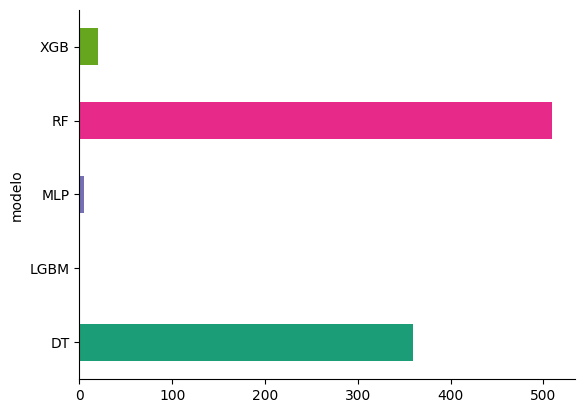

In [62]:
df_preds_test_rf['modelo'] = 'RF'
df_preds_test_xgb['modelo'] = 'XGB'
df_preds_test_mlp['modelo'] = 'MLP'
df_preds_test_lgbm['modelo'] = 'LGBM'
df_preds_test_dt['modelo'] = 'DT'

# Combinar todas las predicciones en un solo DataFrame
df_all_preds = pd.concat([
    df_preds_test_rf.groupby(['producto', 'modelo'], as_index=False).agg({'metric_RMSE': 'first'}),
    df_preds_test_xgb.groupby(['producto', 'modelo'], as_index=False).agg({'metric_RMSE': 'first'}),
    df_preds_test_mlp.groupby(['producto', 'modelo'], as_index=False).agg({'metric_RMSE': 'first'}),
    df_preds_test_lgbm.groupby(['producto', 'modelo'], as_index=False).agg({'metric_RMSE': 'first'}),
    df_preds_test_dt.groupby(['producto', 'modelo'], as_index=False).agg({'metric_RMSE': 'first'})
], ignore_index=True)

#Renombrar columna RMSE
df_all_preds = df_all_preds.rename(columns={'metric_RMSE': 'RMSE'})

#Identificar el mejor modelo por producto 
best_models_per_product = df_all_preds.loc[df_all_preds.groupby('producto')['RMSE'].idxmin()].reset_index(drop=True)

# Ordenamos por producto
best_models_per_product = best_models_per_product.sort_values(by='producto').reset_index(drop=True)

#Guardamos el resultado en un CSV
best_models_per_product.to_csv('Mejores_Modelos_por_Producto.csv', index=False)

#Visuaizacion de los mejores modelos por producto
best_models_per_product.groupby('modelo').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

# Modelo por producto, el mejor para cada producto. Preprocesado y con cluster

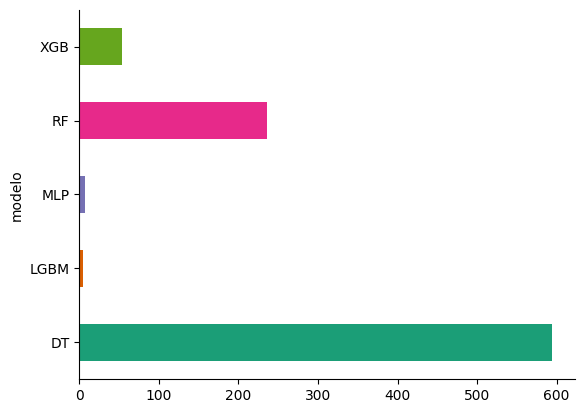

In [76]:
#kmeans clean
df_preds_test_rf_clean_kmeans['modelo'] = 'RF'
df_preds_test_xgb_clean_kmeans['modelo'] = 'XGB'
df_preds_test_mlp_clean_kmeans['modelo'] = 'MLP'
df_preds_test_lgbm_clean_kmeans['modelo'] = 'LGBM'
df_preds_test_dt_clean_kmeans['modelo'] = 'DT'

# Combinar todas las predicciones en un solo DataFrame
df_all_preds_clean_kmeans = pd.concat([
    df_preds_test_rf_clean_kmeans.groupby(['producto', 'modelo'], as_index=False).agg({'metric_RMSE': 'first'}),
    df_preds_test_xgb_clean_kmeans.groupby(['producto', 'modelo'], as_index=False).agg({'metric_RMSE': 'first'}),
    df_preds_test_mlp_clean_kmeans.groupby(['producto', 'modelo'], as_index=False).agg({'metric_RMSE': 'first'}),
    df_preds_test_lgbm_clean_kmeans.groupby(['producto', 'modelo'], as_index=False).agg({'metric_RMSE': 'first'}),
    df_preds_test_dt_clean_kmeans.groupby(['producto', 'modelo'], as_index=False).agg({'metric_RMSE': 'first'})
], ignore_index=True)

#Renombrar columna RMSE
df_all_preds_clean_kmeans = df_all_preds_clean_kmeans.rename(columns={'metric_RMSE': 'RMSE'})

#Identificar el mejor modelo por producto 
best_models_per_product_kmeans = df_all_preds_clean_kmeans.loc[df_all_preds_clean_kmeans.groupby('producto')['RMSE'].idxmin()].reset_index(drop=True)

# Ordenamos por producto
best_models_per_product_kmeans = best_models_per_product_kmeans.sort_values(by='producto').reset_index(drop=True)

#Guardamos el resultado en un CSV
best_models_per_product_kmeans.to_csv('Mejores_Modelos_por_Producto_Kmeans.csv', index=False)

#Visuaizacion de los mejores modelos por producto
best_models_per_product_kmeans.groupby('modelo').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

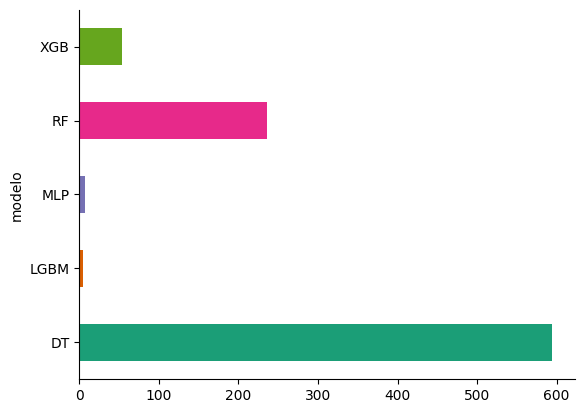

In [77]:
#gmm clean
df_preds_test_rf_clean_gmm['modelo'] = 'RF'
df_preds_test_xgb_clean_gmm['modelo'] = 'XGB'
df_preds_test_mlp_clean_gmm['modelo'] = 'MLP'
df_preds_test_lgbm_clean_gmm['modelo'] = 'LGBM'
df_preds_test_dt_clean_gmm['modelo'] = 'DT'

# Combinar todas las predicciones en un solo DataFrame
df_all_preds_clean_gmm = pd.concat([
    df_preds_test_rf_clean_gmm.groupby(['producto', 'modelo'], as_index=False).agg({'metric_RMSE': 'first'}),
    df_preds_test_xgb_clean_gmm.groupby(['producto', 'modelo'], as_index=False).agg({'metric_RMSE': 'first'}),
    df_preds_test_mlp_clean_gmm.groupby(['producto', 'modelo'], as_index=False).agg({'metric_RMSE': 'first'}),
    df_preds_test_lgbm_clean_gmm.groupby(['producto', 'modelo'], as_index=False).agg({'metric_RMSE': 'first'}),
    df_preds_test_dt_clean_gmm.groupby(['producto', 'modelo'], as_index=False).agg({'metric_RMSE': 'first'})
], ignore_index=True)

#Renombrar columna RMSE
df_all_preds_clean_gmm = df_all_preds_clean_gmm.rename(columns={'metric_RMSE': 'RMSE'})

#Identificar el mejor modelo por producto 
best_models_per_product_gmm= df_all_preds_clean_gmm.loc[df_all_preds_clean_gmm.groupby('producto')['RMSE'].idxmin()].reset_index(drop=True)

# Ordenamos por producto
best_models_per_product_gmm = best_models_per_product_gmm.sort_values(by='producto').reset_index(drop=True)

#Guardamos el resultado en un CSV
best_models_per_product_gmm.to_csv('Mejores_Modelos_por_Producto_Gmm.csv', index=False)

#Visuaizacion de los mejores modelos por producto
best_models_per_product_gmm.groupby('modelo').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

# Modelo por cluster. Todos los clusters mismo modelo. Datos limpios

In [64]:
def preparar_features_cluster(df, cluster_col="cluster", max_lag=7, date_col="idSecuencia"):
    # Agrega por cluster y fecha, preservando calendario/promo
    series = (
        df.groupby([cluster_col, date_col], as_index=False)
          .agg(
              udsVenta=("udsVenta", "sum"),
              bolOpen=("bolOpen", "max"),
              bolHoliday=("bolHoliday", "max"),
              isPromo=("isPromo", "max"),
              dia_semana=("dia_semana", "first"),
              mes=("mes", "first"),
              semana=("semana", "first"),
              semana_mes=("semana_mes", "first"),
          )
          .sort_values([cluster_col, date_col])
    )

    g = series.copy()
    for lag in range(1, max_lag + 1):
        g[f"lag_{lag}"] = g.groupby(cluster_col)["udsVenta"].shift(lag)

    feature_cols = [
        "dia_semana", "mes", "semana", "semana_mes",
        "bolOpen", "bolHoliday", "isPromo",
    ] + [f"lag_{i}" for i in range(1, max_lag + 1)]

    g = g.dropna()  # eliminar filas con lags incompletos
    return g, feature_cols


def rf_model_por_cluster(
    df,
    cluster_col="cluster",
    max_lag=7,
    date_col="idSecuencia",
    param_grid=None,
    metric_opt="RMSE",  # RMSE | MAE | MAPE | wMAPE
):
    datos_feat, feature_cols = preparar_features_cluster(df, cluster_col, max_lag, date_col)

    resultados_test, resultados_val = [], []
    y_true_test_global, y_pred_test_global = [], []
    y_true_val_global, y_pred_val_global = [], []
    preds_rows = []

    if param_grid is None:
        param_grid = {
            "n_estimators": [200, 500],
            "max_depth": [5, 10, None],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2, 5],
            "max_features": ["sqrt", "log2"],
        }

    # scorer según métrica elegida
    def scorer_func(y_true, y_pred):
        return metricas(y_true, y_pred)[metric_opt]

    rf_scorer = make_scorer(lambda yt, yp: -scorer_func(yt, yp))  # negativo para minimizar

    for clus_id, g in datos_feat.groupby(cluster_col):
        if len(g) < max(1, max_lag + 1):
            continue

        train, val, test = temporal_train_val_test_split(
            g,
            date_col=date_col,
            group_col=None,
        )
        if len(train) == 0 or len(test) == 0:
            continue

        X_train, y_train = train[feature_cols], train["udsVenta"]
        X_val, y_val = val[feature_cols], val["udsVenta"]
        X_test, y_test = test[feature_cols], test["udsVenta"]

        try:
            cv = TimeSeriesSplit(n_splits=3) if len(train) >= 30 else 2
            gs = GridSearchCV(
                RandomForestRegressor(random_state=42, n_jobs=-1),
                param_grid=param_grid,
                scoring=rf_scorer,
                cv=cv,
                n_jobs=-1,
            )
            gs.fit(X_train, y_train)
            best_rf = gs.best_estimator_

            # Reentrenar en train + val para predecir test
            X_trainval = pd.concat([X_train, X_val])
            y_trainval = pd.concat([y_train, y_val]) if len(val) else y_train
            best_rf.fit(X_trainval, y_trainval)

            y_pred_test = best_rf.predict(X_test)
            res_test = metricas(y_test, y_pred_test)

            y_pred_val = best_rf.predict(X_val) if len(val) else np.array([])
            res_val = metricas(y_val, y_pred_val) if len(val) else None

            resultados_test.append({"cluster": clus_id, **res_test})
            y_true_test_global.extend(y_test.values)
            y_pred_test_global.extend(y_pred_test)

            df_out = test[[date_col, "udsVenta"]].copy()
            df_out[cluster_col] = clus_id
            df_out["udsVenta_pred"] = y_pred_test
            df_out["abs_error"] = (df_out["udsVenta"] - df_out["udsVenta_pred"]).abs()
            df_out["sq_error"] = (df_out["udsVenta"] - df_out["udsVenta_pred"]) ** 2
            df_out["ape"] = df_out["abs_error"] / df_out["udsVenta"].replace(0, np.nan)
            for k, v in res_test.items():
                df_out[f"metric_{k}"] = v
            preds_rows.append(df_out)

            if res_val is not None and len(val):
                resultados_val.append({"cluster": clus_id, **res_val})
                y_true_val_global.extend(y_val.values)
                y_pred_val_global.extend(y_pred_val)

        except Exception as e:
            print(f"Error en cluster {clus_id}: {e}")

    metricas_globales_test = (
        metricas(np.array(y_true_test_global), np.array(y_pred_test_global))
        if y_true_test_global else None
    )
    metricas_globales_val = (
        metricas(np.array(y_true_val_global), np.array(y_pred_val_global))
        if y_true_val_global else None
    )

    if metricas_globales_test is not None:
        print("Métricas globales RF por cluster (TEST):")
        for k, v in metricas_globales_test.items():
            print(f"{k}: {v:.4f}")
    else:
        print("No se han generado predicciones globales RF por cluster (TEST).")

    if metricas_globales_val is not None:
        print("Métricas globales RF por cluster (VALIDACIÓN):")
        for k, v in metricas_globales_val.items():
            print(f"{k}: {v:.4f}")
    else:
        print("No se han generado predicciones globales RF por cluster (VALIDACIÓN).")

    df_preds_test = (
        pd.concat(preds_rows, ignore_index=True)
        if preds_rows
        else pd.DataFrame(
            columns=[
                cluster_col, date_col, "udsVenta", "udsVenta_pred",
                "abs_error", "sq_error", "ape",
                "metric_MSE", "metric_RMSE", "metric_MAE", "metric_MAPE",
                "metric_wMAPE", "metric_EVS",
            ]
        )
    )

    return metricas_globales_test, metricas_globales_val, df_preds_test

# KMeans
print("RF por cluster KMeans:")
m_test_k, m_val_k, df_preds_cluster_rf_kmeans = rf_model_por_cluster(
    datos_ventas_stock_calendario_clean_cluster_kmeans,
    cluster_col="cluster",
    max_lag=7,
)
df_preds_cluster_rf_kmeans.to_csv("Predicciones_Test_RF_Clean_KMEANS_cluster.csv", index=False)

# GMM
print("RF por cluster GMM:")
m_test_g, m_val_g, df_preds_cluster_rf_gmm = rf_model_por_cluster(
    datos_ventas_stock_calendario_clean_cluster_gmm,
    cluster_col="cluster_gmm",
    max_lag=7,
)
df_preds_cluster_rf_gmm.to_csv("Predicciones_Test_RF_Clean_GMM_cluster.csv", index=False)



RF por cluster KMeans:
Métricas globales RF por cluster (TEST):
MSE: 2967.5893
RMSE: 54.4756
MAE: 37.2853
MAPE: 23.3633
wMAPE: 0.1131
EVS: 0.9425
Métricas globales RF por cluster (VALIDACIÓN):
MSE: 1710.4593
RMSE: 41.3577
MAE: 25.6739
MAPE: 29.1632
wMAPE: 0.0839
EVS: 0.9623
RF por cluster GMM:
Métricas globales RF por cluster (TEST):
MSE: 2911.9244
RMSE: 53.9622
MAE: 37.6231
MAPE: 27.7985
wMAPE: 0.1141
EVS: 0.9436
Métricas globales RF por cluster (VALIDACIÓN):
MSE: 1316.2514
RMSE: 36.2802
MAE: 23.0388
MAPE: 38.2287
wMAPE: 0.0753
EVS: 0.9698


In [65]:
def xgb_model_por_cluster(
    df,
    cluster_col="cluster",
    max_lag=7,
    date_col="idSecuencia",
    min_train_rows=1,
    param_grid=None,
    metric_opt="RMSE",  # RMSE | MAE | MAPE | wMAPE
):
    datos_feat, feature_cols = preparar_features_cluster(df, cluster_col, max_lag, date_col)

    resultados_test, resultados_val = [], []
    y_true_test_global, y_pred_test_global = [], []
    y_true_val_global, y_pred_val_global = [], []
    preds_rows = []

    if param_grid is None:
        param_grid = {
            "n_estimators": [300, 600],
            "max_depth": [3, 6, 8],
            "learning_rate": [0.05, 0.1],
            "subsample": [0.7, 1.0],
            "colsample_bytree": [0.7, 1.0],
            "min_child_weight": [1, 5],
        }

    def scorer_func(y_true, y_pred):
        return metricas(y_true, y_pred)[metric_opt]

    xgb_scorer = make_scorer(lambda yt, yp: -scorer_func(yt, yp))  # minimizar

    for clus_id, g in datos_feat.groupby(cluster_col):
        if len(g) < max(min_train_rows, max_lag + 1):
            continue

        train, val, test = temporal_train_val_test_split(
            g,
            date_col=date_col,
            group_col=None,
        )
        if len(train) == 0 or len(test) == 0:
            continue

        X_train, y_train = train[feature_cols], train["udsVenta"]
        X_val, y_val = val[feature_cols], val["udsVenta"]
        X_test, y_test = test[feature_cols], test["udsVenta"]

        try:
            cv = TimeSeriesSplit(n_splits=3) if len(train) >= 30 else 2
            gs = GridSearchCV(
                XGBRegressor(
                    objective="reg:squarederror",
                    random_state=42,
                    n_jobs=-1,
                    tree_method="hist",
                ),
                param_grid=param_grid,
                scoring=xgb_scorer,
                cv=cv,
                n_jobs=-1,
            )
            gs.fit(X_train, y_train, eval_set=[(X_val, y_val)] if len(val) else None, verbose=False)
            best_xgb = gs.best_estimator_

            # Reentrenar en train + val para predecir test
            X_trainval = pd.concat([X_train, X_val])
            y_trainval = pd.concat([y_train, y_val]) if len(val) else y_train
            best_xgb.fit(X_trainval, y_trainval, verbose=False)

            y_pred_test = best_xgb.predict(X_test)
            res_test = metricas(y_test, y_pred_test)

            y_pred_val = best_xgb.predict(X_val) if len(val) else np.array([])
            res_val = metricas(y_val, y_pred_val) if len(val) else None

            resultados_test.append({"cluster": clus_id, **res_test})
            y_true_test_global.extend(y_test.values)
            y_pred_test_global.extend(y_pred_test)

            df_out = test[[date_col, "udsVenta"]].copy()
            df_out[cluster_col] = clus_id
            df_out["udsVenta_pred"] = y_pred_test
            df_out["abs_error"] = (df_out["udsVenta"] - df_out["udsVenta_pred"]).abs()
            df_out["sq_error"] = (df_out["udsVenta"] - df_out["udsVenta_pred"]) ** 2
            df_out["ape"] = df_out["abs_error"] / df_out["udsVenta"].replace(0, np.nan)
            for k, v in res_test.items():
                df_out[f"metric_{k}"] = v
            preds_rows.append(df_out)

            if res_val is not None and len(val):
                resultados_val.append({"cluster": clus_id, **res_val})
                y_true_val_global.extend(y_val.values)
                y_pred_val_global.extend(y_pred_val)

        except Exception as e:
            print(f"Error en cluster {clus_id}: {e}")

    metricas_globales_test = (
        metricas(np.array(y_true_test_global), np.array(y_pred_test_global))
        if y_true_test_global else None
    )
    metricas_globales_val = (
        metricas(np.array(y_true_val_global), np.array(y_pred_val_global))
        if y_true_val_global else None
    )

    if metricas_globales_test is not None:
        print("Métricas globales XGB por cluster (TEST):")
        for k, v in metricas_globales_test.items():
            print(f"{k}: {v:.4f}")
    else:
        print("No se han generado predicciones globales XGB por cluster (TEST).")

    if metricas_globales_val is not None:
        print("Métricas globales XGB por cluster (VALIDACIÓN):")
        for k, v in metricas_globales_val.items():
            print(f"{k}: {v:.4f}")
    else:
        print("No se han generado predicciones globales XGB por cluster (VALIDACIÓN).")

    df_preds_test = (
        pd.concat(preds_rows, ignore_index=True)
        if preds_rows
        else pd.DataFrame(
            columns=[
                cluster_col, date_col, "udsVenta", "udsVenta_pred",
                "abs_error", "sq_error", "ape",
                "metric_MSE", "metric_RMSE", "metric_MAE", "metric_MAPE",
                "metric_wMAPE", "metric_EVS",
            ]
        )
    )

    return metricas_globales_test, metricas_globales_val, df_preds_test

# KMeans
print("XGB por cluster KMeans:")
m_test_k, m_val_k, df_preds_cluster_xgb_kmeans = xgb_model_por_cluster(
    datos_ventas_stock_calendario_clean_cluster_kmeans,
    cluster_col="cluster",
    max_lag=7,
)
df_preds_cluster_xgb_kmeans.to_csv("Predicciones_Test_XGB_Clean_KMEANS_cluster.csv", index=False)

# GMM
print("XGB por cluster GMM:")
m_test_g, m_val_g, df_preds_cluster_xgb_gmm = xgb_model_por_cluster(
    datos_ventas_stock_calendario_clean_cluster_gmm,
    cluster_col="cluster_gmm",
    max_lag=7,
)
df_preds_cluster_xgb_gmm.to_csv("Predicciones_Test_XGB_Clean_GMM_cluster.csv", index=False)


XGB por cluster KMeans:
Métricas globales XGB por cluster (TEST):
MSE: 3155.4873
RMSE: 56.1737
MAE: 37.6562
MAPE: 19.3455
wMAPE: 0.1142
EVS: 0.9386
Métricas globales XGB por cluster (VALIDACIÓN):
MSE: 362.2848
RMSE: 19.0338
MAE: 8.0455
MAPE: 5.8047
wMAPE: 0.0263
EVS: 0.9919
XGB por cluster GMM:
Métricas globales XGB por cluster (TEST):
MSE: 3298.4875
RMSE: 57.4325
MAE: 39.8858
MAPE: 27.2107
wMAPE: 0.1209
EVS: 0.9361
Métricas globales XGB por cluster (VALIDACIÓN):
MSE: 39.8144
RMSE: 6.3099
MAE: 3.4557
MAPE: 1.8686
wMAPE: 0.0113
EVS: 0.9991


In [68]:
def mlp_model_por_cluster(
    df,
    cluster_col="cluster",
    max_lag=7,
    date_col="idSecuencia",
    min_train_rows=1,
    param_grid=None,
    metric_opt="RMSE",  # RMSE | MAE | MAPE | wMAPE
):
    datos_feat, feature_cols = preparar_features_cluster(df, cluster_col, max_lag, date_col)

    resultados_test, resultados_val = [], []
    y_true_test_global, y_pred_test_global = [], []
    y_true_val_global, y_pred_val_global = [], []
    preds_rows = []

    if param_grid is None:
        param_grid = {
            "mlp__hidden_layer_sizes": [(64, 32), (128, 64)],
            "mlp__activation": ["relu", "tanh"],
            "mlp__alpha": [1e-4, 1e-3],
            "mlp__learning_rate_init": [0.001, 0.01],
        }

    def scorer_func(y_true, y_pred):
        return metricas(y_true, y_pred)[metric_opt]

    mlp_scorer = make_scorer(lambda yt, yp: -scorer_func(yt, yp))

    for clus_id, g in datos_feat.groupby(cluster_col):
        if len(g) < max(1, max_lag + 1):
            continue

        train, val, test = temporal_train_val_test_split(
            g,
            date_col=date_col,
            group_col=None,
        )
        if len(train) == 0 or len(test) == 0:
            continue

        X_train, y_train = train[feature_cols], train["udsVenta"]
        X_val, y_val = val[feature_cols], val["udsVenta"]
        X_test, y_test = test[feature_cols], test["udsVenta"]

        try:
            cv = TimeSeriesSplit(n_splits=3) if len(train) >= 30 else 2
            pipe = Pipeline([
                ("scaler", StandardScaler()),
                ("mlp", MLPRegressor(max_iter=400, random_state=42))
            ])
            gs = GridSearchCV(
                pipe,
                param_grid=param_grid,
                scoring=mlp_scorer,
                cv=cv,
                n_jobs=-1,
            )
            gs.fit(X_train, y_train)
            best_mlp = gs.best_estimator_

            # Reentrenar en train + val para predecir test
            X_trainval = pd.concat([X_train, X_val])
            y_trainval = pd.concat([y_train, y_val]) if len(val) else y_train
            best_mlp.fit(X_trainval, y_trainval)

            y_pred_test = best_mlp.predict(X_test)
            res_test = metricas(y_test, y_pred_test)

            y_pred_val = best_mlp.predict(X_val) if len(val) else np.array([])
            res_val = metricas(y_val, y_pred_val) if len(val) else None

            resultados_test.append({"cluster": clus_id, **res_test})
            y_true_test_global.extend(y_test.values)
            y_pred_test_global.extend(y_pred_test)

            df_out = test[[date_col, "udsVenta"]].copy()
            df_out[cluster_col] = clus_id
            df_out["udsVenta_pred"] = y_pred_test
            df_out["abs_error"] = (df_out["udsVenta"] - df_out["udsVenta_pred"]).abs()
            df_out["sq_error"] = (df_out["udsVenta"] - df_out["udsVenta_pred"]) ** 2
            df_out["ape"] = df_out["abs_error"] / df_out["udsVenta"].replace(0, np.nan)
            for k, v in res_test.items():
                df_out[f"metric_{k}"] = v
            preds_rows.append(df_out)

            if res_val is not None and len(val):
                resultados_val.append({"cluster": clus_id, **res_val})
                y_true_val_global.extend(y_val.values)
                y_pred_val_global.extend(y_pred_val)

        except Exception as e:
            print(f"Error en cluster {clus_id}: {e}")

    metricas_globales_test = (
        metricas(np.array(y_true_test_global), np.array(y_pred_test_global))
        if y_true_test_global else None
    )
    metricas_globales_val = (
        metricas(np.array(y_true_val_global), np.array(y_pred_val_global))
        if y_true_val_global else None
    )

    if metricas_globales_test is not None:
        print("Métricas globales MLP por cluster (TEST):")
        for k, v in metricas_globales_test.items():
            print(f"{k}: {v:.4f}")
    else:
        print("No se han generado predicciones globales MLP por cluster (TEST).")

    if metricas_globales_val is not None:
        print("Métricas globales MLP por cluster (VALIDACIÓN):")
        for k, v in metricas_globales_val.items():
            print(f"{k}: {v:.4f}")
    else:
        print("No se han generado predicciones globales MLP por cluster (VALIDACIÓN).")

    df_preds_test = (
        pd.concat(preds_rows, ignore_index=True)
        if preds_rows
        else pd.DataFrame(
            columns=[
                cluster_col, date_col, "udsVenta", "udsVenta_pred",
                "abs_error", "sq_error", "ape",
                "metric_MSE", "metric_RMSE", "metric_MAE", "metric_MAPE",
                "metric_wMAPE", "metric_EVS",
            ]
        )
    )

    return metricas_globales_test, metricas_globales_val, df_preds_test

# KMeans
print("MLP por cluster KMeans:")
m_test_k, m_val_k, df_preds_cluster_mlp_kmeans = mlp_model_por_cluster(
    datos_ventas_stock_calendario_clean_cluster_kmeans,
    cluster_col="cluster",
    max_lag=7,
)
df_preds_cluster_mlp_kmeans.to_csv("Predicciones_Test_MLP_Clean_KMEANS_cluster.csv", index=False)

# GMM
print("MLP por cluster GMM:")
m_test_g, m_val_g, df_preds_cluster_mlp_gmm = mlp_model_por_cluster(
    datos_ventas_stock_calendario_clean_cluster_gmm,
    cluster_col="cluster_gmm",
    max_lag=7,
)
df_preds_cluster_mlp_gmm.to_csv("Predicciones_Test_MLP_Clean_GMM_cluster.csv", index=False)


MLP por cluster KMeans:
Métricas globales MLP por cluster (TEST):
MSE: 3639.5270
RMSE: 60.3285
MAE: 40.4434
MAPE: 22.7786
wMAPE: 0.1226
EVS: 0.9294
Métricas globales MLP por cluster (VALIDACIÓN):
MSE: 2032.1453
RMSE: 45.0793
MAE: 29.4261
MAPE: 23.5930
wMAPE: 0.0962
EVS: 0.9549
MLP por cluster GMM:
Métricas globales MLP por cluster (TEST):
MSE: 3491.0762
RMSE: 59.0853
MAE: 42.1957
MAPE: 30.5036
wMAPE: 0.1279
EVS: 0.9324
Métricas globales MLP por cluster (VALIDACIÓN):
MSE: 2013.2906
RMSE: 44.8697
MAE: 27.9150
MAPE: 16.1965
wMAPE: 0.0913
EVS: 0.9529


In [ ]:
def lgbm_model_por_cluster(
    df,
    cluster_col="cluster",
    max_lag=7,
    date_col="idSecuencia",
    min_train_rows=1,
    lgbm_params=None,
):
    datos_feat, feature_cols = preparar_features_cluster(df, cluster_col, max_lag, date_col)

    resultados_test, resultados_val = [], []
    y_true_test_global, y_pred_test_global = [], []
    y_true_val_global, y_pred_val_global = [], []
    preds_rows = []

    base_params = dict(
        objective="regression",
        random_state=42,
        n_jobs=-1,
        verbosity=-1,
        n_estimators=800,
        learning_rate=0.05,
        num_leaves=63,
        max_depth=-1,
        subsample=0.9,
        colsample_bytree=0.9,
        min_child_samples=20,
        reg_alpha=0.1,
        reg_lambda=0.5,
    )
    if lgbm_params:
        base_params.update(lgbm_params)

    for clus_id, g in datos_feat.groupby(cluster_col):
        if len(g) < max(min_train_rows, max_lag + 1):
            continue

        train, val, test = temporal_train_val_test_split(
            g,
            date_col=date_col,
            group_col=None,
        )
        if len(train) == 0 or len(test) == 0:
            continue

        X_train, y_train = train[feature_cols], train["udsVenta"]
        X_val, y_val = val[feature_cols], val["udsVenta"]
        X_test, y_test = test[feature_cols], test["udsVenta"]

        try:
            # 1) Entrena y evalúa en validación
            model = LGBMRegressor(**base_params)
            model.fit(X_train, y_train)

            y_pred_val = model.predict(X_val) if len(val) else np.array([])
            res_val = metricas(y_val, y_pred_val) if len(val) else None

            # 2) Reentrena en train+val y evalúa en test
            X_trainval = pd.concat([X_train, X_val])
            y_trainval = pd.concat([y_train, y_val]) if len(val) else y_train
            model.fit(X_trainval, y_trainval)

            y_pred_test = model.predict(X_test)
            res_test = metricas(y_test, y_pred_test)

            resultados_test.append({"cluster": clus_id, **res_test})
            y_true_test_global.extend(y_test.values)
            y_pred_test_global.extend(y_pred_test)

            df_out = test[[date_col, "udsVenta"]].copy()
            df_out[cluster_col] = clus_id
            df_out["udsVenta_pred"] = y_pred_test
            df_out["abs_error"] = (df_out["udsVenta"] - df_out["udsVenta_pred"]).abs()
            df_out["sq_error"] = (df_out["udsVenta"] - df_out["udsVenta_pred"]) ** 2
            df_out["ape"] = df_out["abs_error"] / df_out["udsVenta"].replace(0, np.nan)
            for k, v in res_test.items():
                df_out[f"metric_{k}"] = v
            preds_rows.append(df_out)

            if res_val is not None and len(val):
                resultados_val.append({"cluster": clus_id, **res_val})
                y_true_val_global.extend(y_val.values)
                y_pred_val_global.extend(y_pred_val)

        except Exception as e:
            print(f"Error en cluster {clus_id}: {e}")

    metricas_globales_test = (
        metricas(np.array(y_true_test_global), np.array(y_pred_test_global))
        if y_true_test_global else None
    )
    metricas_globales_val = (
        metricas(np.array(y_true_val_global), np.array(y_pred_val_global))
        if y_true_val_global else None
    )

    if metricas_globales_test is not None:
        print("Métricas globales LGBM por cluster (TEST):")
        for k, v in metricas_globales_test.items():
            print(f"{k}: {v:.4f}")
    else:
        print("No se han generado predicciones globales LGBM por cluster (TEST).")

    if metricas_globales_val is not None:
        print("Métricas globales LGBM por cluster (VALIDACIÓN):")
        for k, v in metricas_globales_val.items():
            print(f"{k}: {v:.4f}")
    else:
        print("No se han generado predicciones globales LGBM por cluster (VALIDACIÓN).")

    df_preds_test = (
        pd.concat(preds_rows, ignore_index=True)
        if preds_rows
        else pd.DataFrame(
            columns=[
                cluster_col, date_col, "udsVenta", "udsVenta_pred",
                "abs_error", "sq_error", "ape",
                "metric_MSE", "metric_RMSE", "metric_MAE", "metric_MAPE",
                "metric_wMAPE", "metric_EVS",
            ]
        )
    )

    return metricas_globales_test, metricas_globales_val, df_preds_test

# KMeans
print("LGBM por cluster KMeans:")
m_test_k, m_val_k, df_preds_cluster_lgbm_kmeans = lgbm_model_por_cluster(
    datos_ventas_stock_calendario_clean_cluster_kmeans,
    cluster_col="cluster",
    max_lag=7,
)
df_preds_cluster_lgbm_kmeans.to_csv("Predicciones_Test_LGBM_Clean_KMEANS_cluster.csv", index=False)

# GMM
print("LGBM por cluster GMM:")
m_test_g, m_val_g, df_preds_cluster_lgbm_gmm = lgbm_model_por_cluster(
    datos_ventas_stock_calendario_clean_cluster_gmm,
    cluster_col="cluster_gmm",
    max_lag=7,
)
df_preds_cluster_lgbm_gmm.to_csv("Predicciones_Test_LGBM_Clean_GMM_cluster.csv", index=False)


LGBM por cluster KMeans:
Métricas globales LGBM por cluster (TEST):
MSE: 3606.9724
RMSE: 60.0581
MAE: 41.4960
MAPE: 25.9544
wMAPE: 0.1258
EVS: 0.9299
Métricas globales LGBM por cluster (VALIDACIÓN):
MSE: 5128.1619
RMSE: 71.6112
MAE: 49.9378
MAPE: 45.7435
wMAPE: 0.1633
EVS: 0.8900
LGBM por cluster GMM:
Métricas globales LGBM por cluster (TEST):
MSE: 3845.3193
RMSE: 62.0106
MAE: 44.2483
MAPE: 41.0554
wMAPE: 0.1342
EVS: 0.9256
Métricas globales LGBM por cluster (VALIDACIÓN):
MSE: 4783.8418
RMSE: 69.1653
MAE: 49.9008
MAPE: 74.2203
wMAPE: 0.1632
EVS: 0.8943


In [71]:
def dt_model_por_cluster(
    df,
    cluster_col="cluster",
    max_lag=7,
    date_col="idSecuencia",
    min_train_rows=1,
    param_grid=None,
    metric_opt="RMSE",  # RMSE | MAE | MAPE | wMAPE
):
    datos_feat, feature_cols = preparar_features_cluster(df, cluster_col, max_lag, date_col)

    resultados_test, resultados_val = [], []
    y_true_test_global, y_pred_test_global = [], []
    y_true_val_global, y_pred_val_global = [], []
    preds_rows = []

    if param_grid is None:
        param_grid = {
            "max_depth": [3, 5, 10, None],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 5],
            "max_features": ["auto", "sqrt", "log2", None],
        }

    def scorer_func(y_true, y_pred):
        return metricas(y_true, y_pred)[metric_opt]

    dt_scorer = make_scorer(lambda yt, yp: -scorer_func(yt, yp))

    for clus_id, g in datos_feat.groupby(cluster_col):
        if len(g) < max(min_train_rows, max_lag + 1):
            continue

        train, val, test = temporal_train_val_test_split(
            g,
            date_col=date_col,
            group_col=None,
        )
        if len(train) == 0 or len(test) == 0:
            continue

        X_train, y_train = train[feature_cols], train["udsVenta"]
        X_val, y_val = val[feature_cols], val["udsVenta"]
        X_test, y_test = test[feature_cols], test["udsVenta"]

        try:
            cv = TimeSeriesSplit(n_splits=3) if len(train) >= 30 else 2
            gs = GridSearchCV(
                DecisionTreeRegressor(random_state=42),
                param_grid=param_grid,
                scoring=dt_scorer,
                cv=cv,
                n_jobs=-1,
            )
            gs.fit(X_train, y_train)
            best_dt = gs.best_estimator_

            # Reentrenar en train + val para predecir test
            X_trainval = pd.concat([X_train, X_val])
            y_trainval = pd.concat([y_train, y_val]) if len(val) else y_train
            best_dt.fit(X_trainval, y_trainval)

            y_pred_test = best_dt.predict(X_test)
            res_test = metricas(y_test, y_pred_test)

            y_pred_val = best_dt.predict(X_val) if len(val) else np.array([])
            res_val = metricas(y_val, y_pred_val) if len(val) else None

            resultados_test.append({"cluster": clus_id, **res_test})
            y_true_test_global.extend(y_test.values)
            y_pred_test_global.extend(y_pred_test)

            df_out = test[[date_col, "udsVenta"]].copy()
            df_out[cluster_col] = clus_id
            df_out["udsVenta_pred"] = y_pred_test
            df_out["abs_error"] = (df_out["udsVenta"] - df_out["udsVenta_pred"]).abs()
            df_out["sq_error"] = (df_out["udsVenta"] - df_out["udsVenta_pred"]) ** 2
            df_out["ape"] = df_out["abs_error"] / df_out["udsVenta"].replace(0, np.nan)
            for k, v in res_test.items():
                df_out[f"metric_{k}"] = v
            preds_rows.append(df_out)

            if res_val is not None and len(val):
                resultados_val.append({"cluster": clus_id, **res_val})
                y_true_val_global.extend(y_val.values)
                y_pred_val_global.extend(y_pred_val)

        except Exception as e:
            print(f"Error en cluster {clus_id}: {e}")

    metricas_globales_test = (
        metricas(np.array(y_true_test_global), np.array(y_pred_test_global))
        if y_true_test_global else None
    )
    metricas_globales_val = (
        metricas(np.array(y_true_val_global), np.array(y_pred_val_global))
        if y_true_val_global else None
    )

    if metricas_globales_test is not None:
        print("Métricas globales DT por cluster (TEST):")
        for k, v in metricas_globales_test.items():
            print(f"{k}: {v:.4f}")
    else:
        print("No se han generado predicciones globales DT por cluster (TEST).")

    if metricas_globales_val is not None:
        print("Métricas globales DT por cluster (VALIDACIÓN):")
        for k, v in metricas_globales_val.items():
            print(f"{k}: {v:.4f}")
    else:
        print("No se han generado predicciones globales DT por cluster (VALIDACIÓN).")

    df_preds_test = (
        pd.concat(preds_rows, ignore_index=True)
        if preds_rows
        else pd.DataFrame(
            columns=[
                cluster_col, date_col, "producto", "udsVenta", "udsVenta_pred",
                "abs_error", "sq_error", "ape",
                "metric_MSE", "metric_RMSE", "metric_MAE", "metric_MAPE",
                "metric_wMAPE", "metric_EVS", 
            ]
        )
    )

    return metricas_globales_test, metricas_globales_val, df_preds_test

# KMeans
print("DT por cluster KMeans:")
m_test_k, m_val_k, df_preds_cluster_dt_kmeans = dt_model_por_cluster(
    datos_ventas_stock_calendario_clean_cluster_kmeans,
    cluster_col="cluster",
    max_lag=7,
)
df_preds_cluster_dt_kmeans.to_csv("Predi cciones_Test_DT_Clean_KMEANS_cluster.csv", index=False)

# GMM
print("DT por cluster GMM:")
m_test_g, m_val_g, df_preds_cluster_dt_gmm = dt_model_por_cluster(
    datos_ventas_stock_calendario_clean_cluster_gmm,
    cluster_col="cluster_gmm",
    max_lag=7,
)
df_preds_cluster_dt_gmm.to_csv("Predicciones_Test_DT_Clean_GMM_cluster.csv", index=False)


DT por cluster KMeans:
Métricas globales DT por cluster (TEST):
MSE: 5300.9571
RMSE: 72.8077
MAE: 45.5693
MAPE: 26.6308
wMAPE: 0.1382
EVS: 0.8972
Métricas globales DT por cluster (VALIDACIÓN):
MSE: 3956.7539
RMSE: 62.9027
MAE: 39.1140
MAPE: 45.8060
wMAPE: 0.1279
EVS: 0.9143
DT por cluster GMM:
Métricas globales DT por cluster (TEST):
MSE: 4683.1017
RMSE: 68.4332
MAE: 46.0558
MAPE: 23.1812
wMAPE: 0.1396
EVS: 0.9091
Métricas globales DT por cluster (VALIDACIÓN):
MSE: 3725.7301
RMSE: 61.0388
MAE: 36.6630
MAPE: 36.7549
wMAPE: 0.1199
EVS: 0.9146


# Modelo por cluster, el mejor para cada cluster

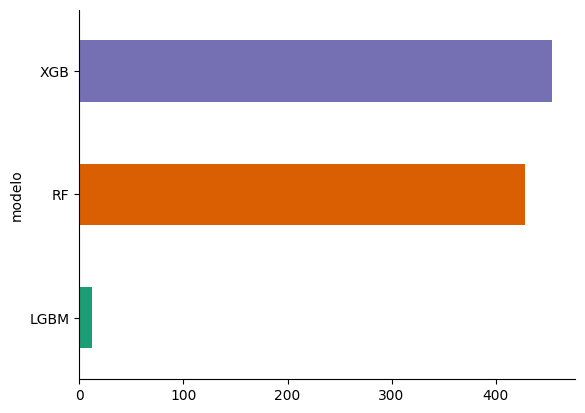

In [72]:
df_preds_cluster_rf_kmeans['modelo'] = 'RF'
df_preds_cluster_xgb_kmeans['modelo'] = 'XGB'
df_preds_cluster_mlp_kmeans['modelo'] = 'MLP'
df_preds_cluster_lgbm_kmeans['modelo'] = 'LGBM'
df_preds_cluster_dt_kmeans['modelo'] = 'DT'

# Combinar todas las predicciones en un solo DataFrame
df_all_preds_kmeans = pd.concat([
    df_preds_cluster_rf_kmeans.groupby(['cluster', 'modelo'], as_index=False).agg({'metric_RMSE': 'first'}),
    df_preds_cluster_xgb_kmeans.groupby(['cluster', 'modelo'], as_index=False).agg({'metric_RMSE': 'first'}),
    df_preds_cluster_mlp_kmeans.groupby(['cluster', 'modelo'], as_index=False).agg({'metric_RMSE': 'first'}),
    df_preds_cluster_lgbm_kmeans.groupby(['cluster', 'modelo'], as_index=False).agg({'metric_RMSE': 'first'}),
    df_preds_cluster_dt_kmeans.groupby(['cluster', 'modelo'], as_index=False).agg({'metric_RMSE': 'first'})
], ignore_index=True)

#Renombrar columna RMSE
df_all_preds_kmeans = df_all_preds_kmeans.rename(columns={'metric_RMSE': 'RMSE'})

#Identificar el mejor modelo por cluster
best_models_per_cluster = df_all_preds_kmeans.loc[df_all_preds_kmeans.groupby('cluster')['RMSE'].idxmin()].reset_index(drop=True)

# Añadir columna de producto
best_models_per_cluster = pd.merge(best_models_per_cluster,
         datos_ventas_stock_calendario_clean_cluster_kmeans[['cluster', 'producto']].drop_duplicates(),
         on='cluster', how='left')

# Ordenamos por producto
best_models_per_cluster = best_models_per_cluster.sort_values(by='producto').reset_index(drop=True)

#Guardamos el resultado en un CSV
best_models_per_cluster.to_csv('Mejores_Modelos_por_Cluster_Kmeans.csv', index=False)

#Visuaizacion de los mejores modelos por producto
best_models_per_cluster.groupby('modelo').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

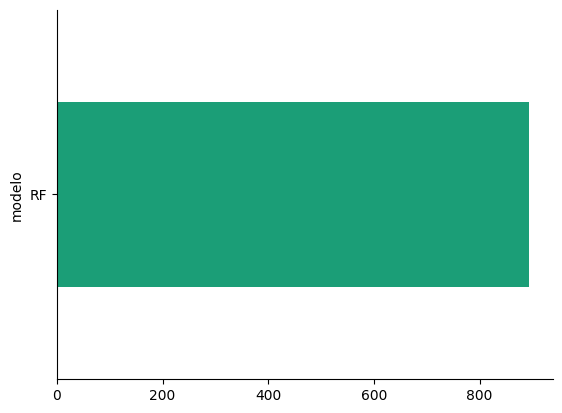

In [74]:
df_preds_cluster_rf_gmm['modelo'] = 'RF'
df_preds_cluster_xgb_gmm['modelo'] = 'XGB'
df_preds_cluster_mlp_gmm['modelo'] = 'MLP'
df_preds_cluster_lgbm_gmm['modelo'] = 'LGBM'
df_preds_cluster_dt_gmm['modelo'] = 'DT'

# Combinar todas las predicciones en un solo DataFrame
df_all_preds_gmm = pd.concat([
    df_preds_cluster_rf_gmm.groupby(['cluster_gmm', 'modelo'], as_index=False).agg({'metric_RMSE': 'first'}),
    df_preds_cluster_xgb_gmm.groupby(['cluster_gmm', 'modelo'], as_index=False).agg({'metric_RMSE': 'first'}),
    df_preds_cluster_mlp_gmm.groupby(['cluster_gmm', 'modelo'], as_index=False).agg({'metric_RMSE': 'first'}),
    df_preds_cluster_lgbm_gmm.groupby(['cluster_gmm', 'modelo'], as_index=False).agg({'metric_RMSE': 'first'}),
    df_preds_cluster_dt_gmm.groupby(['cluster_gmm', 'modelo'], as_index=False).agg({'metric_RMSE': 'first'})
], ignore_index=True)

#Renombrar columna RMSE
df_all_preds_gmm = df_all_preds_gmm.rename(columns={'metric_RMSE': 'RMSE'})

#Identificar el mejor modelo por cluster
best_models_per_cluster_gmm = df_all_preds_gmm.loc[df_all_preds_gmm.groupby('cluster_gmm')['RMSE'].idxmin()].reset_index(drop=True)

# Añadir columna de producto
best_models_per_cluster_gmm = pd.merge(best_models_per_cluster_gmm,
         datos_ventas_stock_calendario_clean_cluster_gmm[['cluster_gmm', 'producto']].drop_duplicates(),
         on='cluster_gmm', how='left')

# Ordenamos por producto
best_models_per_cluster_gmm = best_models_per_cluster_gmm.sort_values(by='producto').reset_index(drop=True)

#Guardamos el resultado en un CSV
best_models_per_cluster_gmm.to_csv('Mejores_Modelos_por_Cluster_GMM.csv', index=False)

#Visuaizacion de los mejores modelos por producto
best_models_per_cluster_gmm.groupby('modelo').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

# Exportación del modelo Naive para comparativa

In [75]:
# Sacar RMSE por producto para el modelo naive
df_preds_test_naive = df_preds_test_naive.groupby(['producto'], as_index=False).agg({'metric_RMSE': 'first'})

# Renombrar columna RMSE
df_preds_test_naive_renamed = df_preds_test_naive.rename(columns={'metric_RMSE': 'RMSE'})


#Exportar a CSV
df_preds_test_naive_renamed.to_csv('Predicciones_Test_Naive_Modelo.csv', index=False)